# Part 3: Machine Learning

Modeling part is all about trying different models, tweaking hyperparameters, evaluation, finding creative ways to engineer features and so on.

### Steps:
1. Baseline Model
2. ARIMA
3. Sentiment Analysis
4. Features Selection with XGBoost
5. Deep Neural Networks 
 - 5.1 LSTM Network
 - 5.2 Convolutional Network
 - 5.3 Combined Stocks Data
 - 5.4 Bayesian Optimization
6. Pattern Recognition by Hand
7. Q-Learning

## Importing Libraries

In [1]:
# https:/onepagecode.substack.com
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import warnings
import numpy as np
from numpy import array
from importlib import reload # to reload modules if we made changes to them without restarting kernel
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier # for features importance

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 227 # native screen dpi for my computer

This code imports various necessary libraries such as os, pandas, matplotlib, seaborn, warnings, numpy, and others. It filters out warning messages, sets the dpi for the matplotlib plots, and imports specific modules like GaussianNB from sklearn and XGBClassifier from xgboost.

In [2]:
# https:/onepagecode.substack.com
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, accuracy_score
from pandas.plotting import autocorrelation_plot

This code imports various modules and functions from different libraries for a stock prediction project using machine learning. The statsmodels module is used for time series analysis and modeling, including ARIMA and SARIMAX models. Functions like plot_pacf and plot_acf are used for plotting autocorrelation and partial autocorrelation plots. The sklearn module is used for evaluating the model's performance metrics such as mean squared error, confusion matrix, f1 score, and accuracy score. The pandas.plotting module is used for plotting autocorrelation plots for the data.

In [3]:
# https:/onepagecode.substack.com
import tensorflow.keras as keras
from tensorflow.python.keras.optimizer_v2 import rmsprop
from functools import partial
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, TimeDistributed, LSTM, Dense, Bidirectional, Dropout, ConvLSTM2D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Convolution1D, BatchNormalization, LeakyReLU
from bayes_opt import BayesianOptimization

from tensorflow.keras.utils import plot_model

This code imports various libraries needed for stock prediction using machine learning. It imports the TensorFlow Keras library, the RMSprop optimizer from TensorFlow, the partial function from the functools library, the optimizers module from TensorFlow Keras, the Sequential and Model classes from TensorFlow Keras models, and different layers from TensorFlow Keras layers.  The code also imports the BayesianOptimization class from a library called bayes_opt, and the plot_model function from TensorFlow Keras utils.  Overall, this code sets up the necessary libraries and functions
for stock prediction using machine learning and Bayesian optimization.

In [5]:
# https:/onepagecode.substack.com
import functions
import plotting

This code imports two modules: "functions" and "plotting". These modules are likely custom modules written for the purpose of stock prediction using machine learning.   The "functions" module likely contains functions that handle various calculations and operations related to stock prediction, such as data preprocessing, feature engineering, model training, and model evaluation.  The "plotting" module likely contains functions to visualize and plot the results of the stock prediction, such as plotting the actual stock prices versus predicted values, visualizing the performance of different models, or plotting various metrics related to the prediction
accuracy.  By importing these modules, the code can access the functionality provided by these modules and use it for its stock prediction task.

In [6]:
# https:/onepagecode.substack.com
np.random.seed(66)

This line of code sets the random seed value to 66 for the numpy library. Setting the random seed ensures that the random numbers generated by the program are reproducible. This is useful when working with machine learning algorithms that involve random elements, as it allows for consistent results to be obtained each time the program is run.

# Loading Data

Reading stocks' data and keeping it in dictionary **stocks**. `Date` feature becomes index

In [7]:
# https:/onepagecode.substack.com
files = os.listdir('data/stocks')
stocks = {}
for file in files:
    if file.split('.')[1] == 'csv':
        name = file.split('.')[0]
        stocks[name] = pd.read_csv('data/stocks/'+file, index_col='Date')
        stocks[name].index = pd.to_datetime(stocks[name].index)

This code is for stock prediction using machine learning. It starts by accessing a directory called 'data/stocks' and listing all the files inside it. It then creates an empty dictionary called 'stocks'.   Using a loop, the code checks each file in the directory and filters out only the ones with the file extension '.csv'. For each eligible file, it extracts the name (without the extension) and assigns it to the variable 'name'.   Next, it reads the CSV file using pandas' 'read_csv' function and assigns it to the dictionary 'stocks' with the name as the key. The 'index_col' parameter is set to 'Date', indicating that the 'Date' column will be used as the index for the data.  Finally, the code converts the index column to datetime format using pandas' 'to_datetime' function, ensuring that the dates are formatted correctly for further analysis.

# 1. Baseline Model

Baseline model would serve as a benchmark for comparing to more complex models.

In [8]:
# https:/onepagecode.substack.com
def baseline_model(stock):
    '''
    \n\n
    Input: Series or Array
    Returns: Accuracy Score
    Function generates random numbers [0,1] and compares them with true values
    \n\n
    '''
    baseline_predictions = np.random.randint(0, 2, len(stock))
    accuracy = accuracy_score(functions.binary(stock), baseline_predictions)
    return accuracy

This code defines a function called "baseline_model" that takes in a series or array of stock data. The function generates a series of random numbers between 0 and 1, with the same length as the input stock data. These random numbers are then compared with the true values of the stock data using a binary classification approach. The accuracy of these baseline predictions is calculated using the "accuracy_score" function, and this accuracy score is returned as the output of the function. The code uses the NumPy library for generating random numbers and the "functions.binary" function to convert the input stock data into a binary format.

### Accuracy

In [9]:
# https:/onepagecode.substack.com
baseline_accuracy = baseline_model(stocks['tsla'].Return)
print('Baseline model accuracy: {:.1f}%'.format(baseline_accuracy * 100))

Baseline model accuracy: 50.1%


This code computes the accuracy of a baseline model for stock prediction using machine learning. It passes the returns data of the TSLA stock to the "baseline_model" function and stores the computed accuracy in the variable "baseline_accuracy". The next line prints the accuracy in percentage format.

### Accuracy Distribution

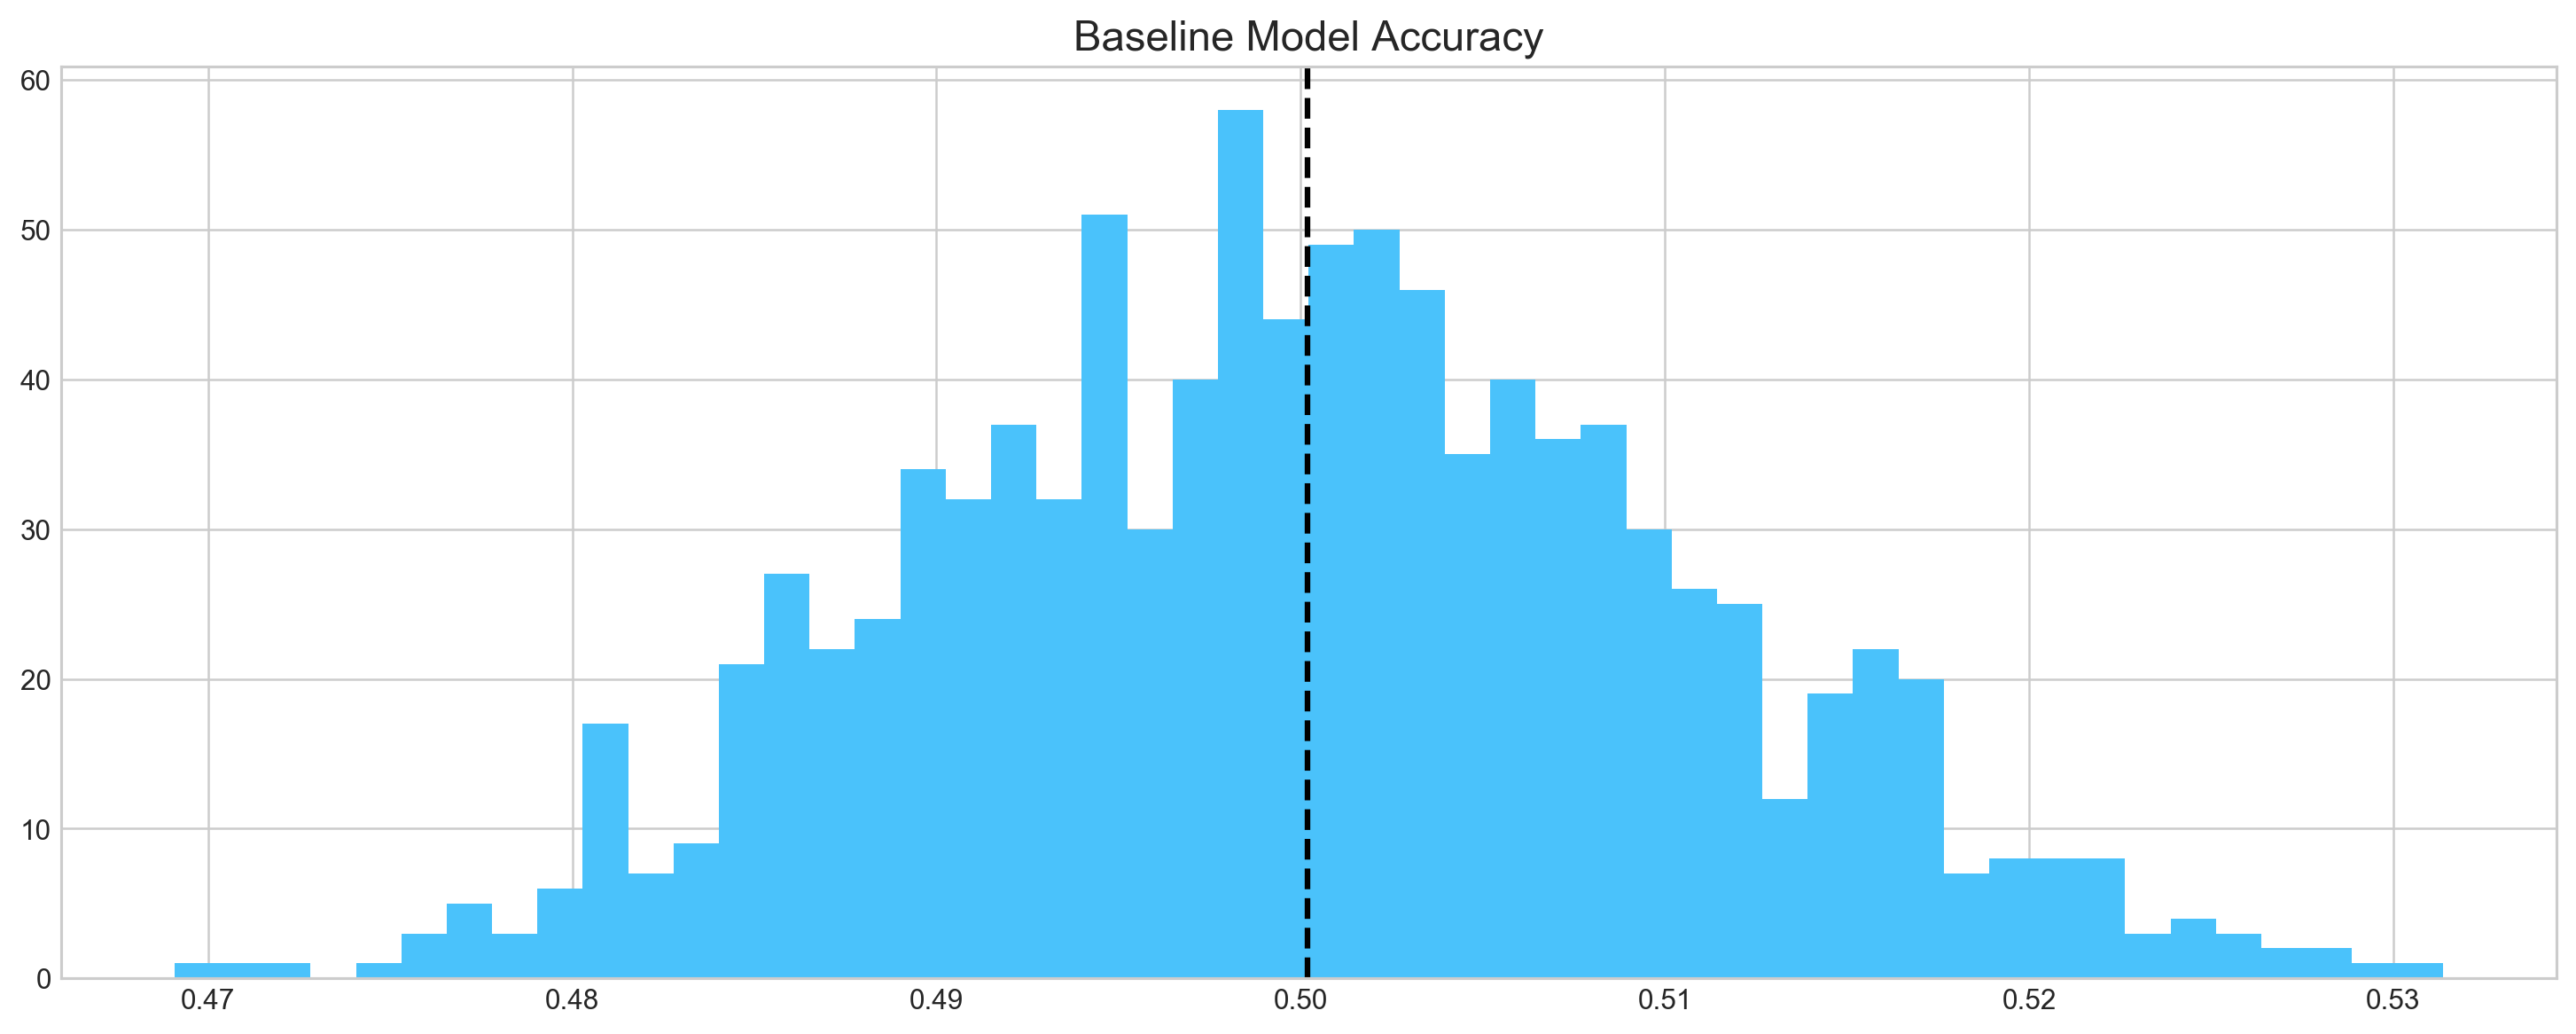

In [10]:
# https:/onepagecode.substack.com
base_preds = []
for i in range(1000):
    base_preds.append(baseline_model(stocks['tsla'].Return))
    
plt.figure(figsize=(16,6))
plt.style.use('seaborn-whitegrid')
plt.hist(base_preds, bins=50, facecolor='#4ac2fb')
plt.title('Baseline Model Accuracy', fontSize=15)
plt.axvline(np.array(base_preds).mean(), c='k', ls='--', lw=2)
plt.show()

This code snippet starts by initializing an empty list called "base_preds". Then, it runs a loop 1000 times and calls a function called "baseline_model" with the argument "stocks['tsla'].Return" for each iteration. The return value of the function call is appended to the "base_preds" list.   After the loop, the code creates a figure with a size of 16x6 using matplotlib. It sets the style to "seaborn-whitegrid" and creates a histogram using the data in the "base_preds" list. The histogram has 50 bins and uses the color '#4ac2fb'.   A title "Baseline Model Accuracy" is added to the plot with a font size of 15. The code also adds a vertical line at the mean value of the "base_preds" array, using a black color and a dashed line style. Finally, the plot is displayed.

### Conclusion

Baseline model on average has 50% accuracy. We take this number as a guideline for our more complex models

# 2. ARIMA

AutoRegressive Integrated Moving Average (ARIMA) is a model that captures a suite of different standard temporal structures in time series data.

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

We will split train and test data to evaluate performance of ARIMA model.

In [11]:
# https:/onepagecode.substack.com
print('Tesla historical data contains {} entries'.format(stocks['tsla'].shape[0]))
stocks['tsla'][['Return']].head()

Tesla historical data contains 2296 entries


Return
Date              
2010-07-28   0.008
2010-07-29  -0.020
2010-07-30  -0.013
2010-08-02   0.020
2010-08-03   0.045

This code prints the number of entries in the historical data of Tesla stocks. It uses the 'format' function to insert the value of the number of entries into the print statement. The next line of code retrieves the first few rows of the 'Return' column from the historical data of Tesla stocks and displays them.

### Autocorrelation

Let's take a look at the `Autocorrelation Function` below. The graph shows how time series **data points** correlate between each other. We should ignore first value in the graph that shows perfect correlation (value = 1), because it tells how **data point** is correlated to itself. What's important in this graph is how **first** data point is correlated to **second**, **third** and so on. We can see that it's so weak, it's close to zero. What does it mean to our analysis? It means that ARIMA is pretty much useless here, because it uses previous data points to predict following.

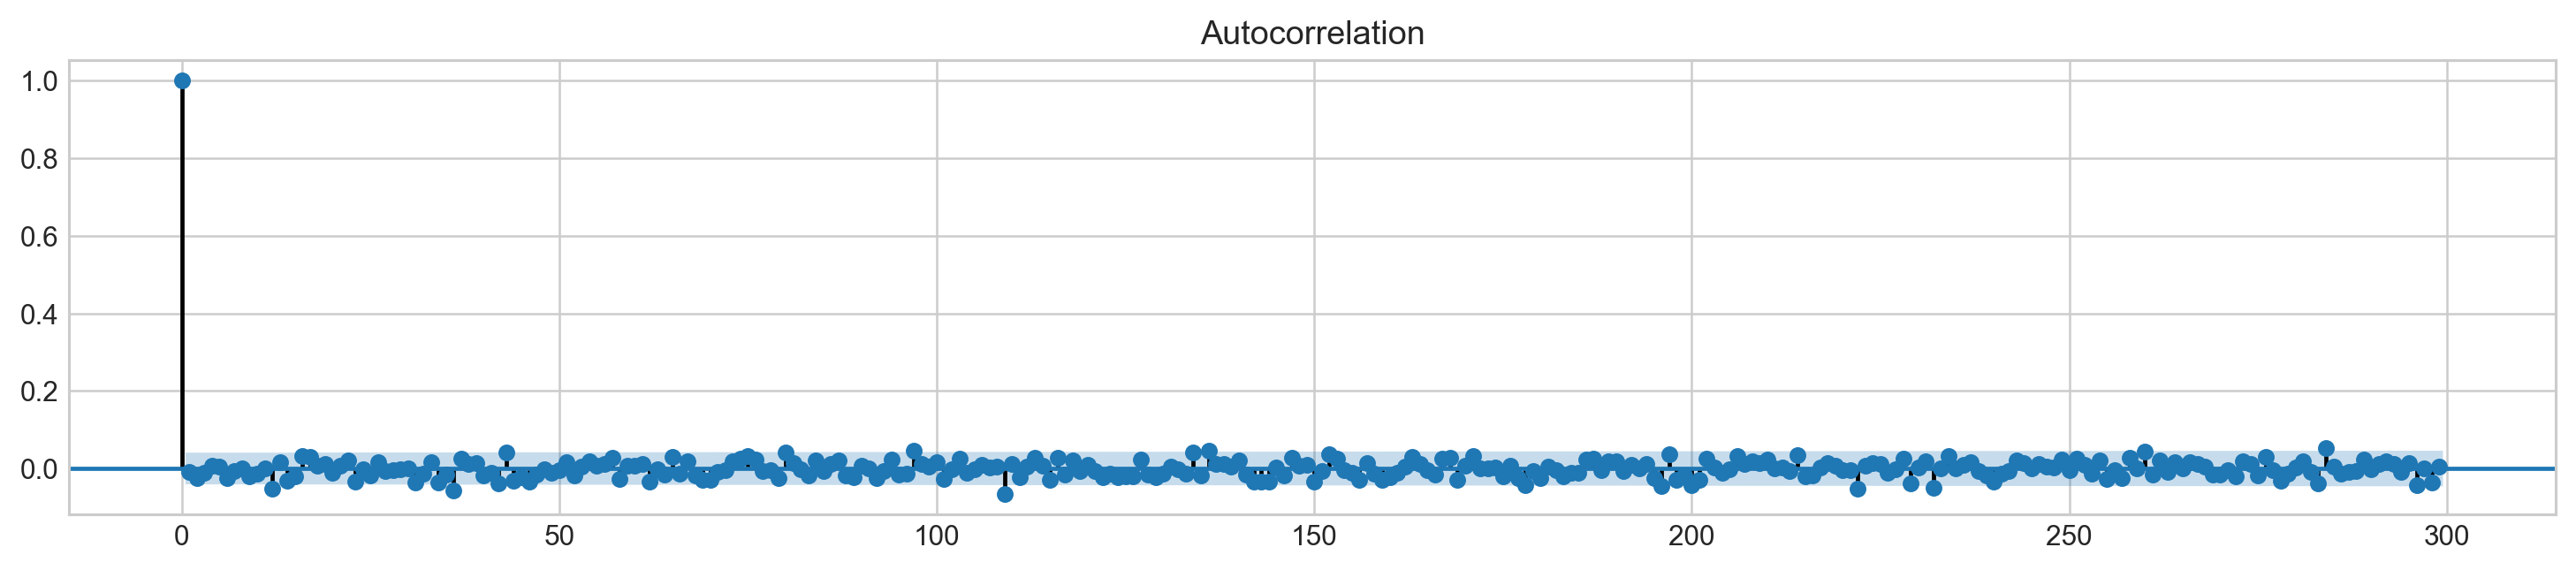

In [12]:
# https:/onepagecode.substack.com
plt.rcParams['figure.figsize'] = (16, 3)
plot_acf(stocks['tsla'].Return, lags=range(300))
plt.show()

This code is using the matplotlib library to plot the autocorrelation function (ACF) of the returns of a stock with the ticker symbol 'tsla'. The ACF measures the correlation between a stock's returns and its past returns at different time lags. The plot is set to have a figure size of 16x3. The plot created will display the ACF with lags ranging from 0 to 299.

To make a conclusion we're going to try different orders and see how well they perform on a given data.

In [13]:
# https:/onepagecode.substack.com
orders = [(0,0,0),(1,0,0),(0,1,0),(0,0,1),(1,1,0)]

train = list(stocks['tsla']['Return'][1000:1900].values)
test = list(stocks['tsla']['Return'][1900:2300].values)

all_predictions = {}

for order in orders:
    
    try:
        history = train.copy()
        order_predictions = []
        
        for i in range(len(test)):
            
            model = ARIMA(history, order=order) # defining ARIMA model
            model_fit = model.fit(disp=0) # fitting model
            y_hat = model_fit.forecast() # predicting 'return'
            order_predictions.append(y_hat[0][0]) # first element ([0][0]) is a prediction
            history.append(test[i]) # simply adding following day 'return' value to the model    
            print('Prediction: {} of {}'.format(i+1,len(test)), end='\r')
        
        accuracy = accuracy_score( 
            functions.binary(test), 
            functions.binary(order_predictions) 
        )        
        print('                             ', end='\r')
        print('{} - {:.1f}% accuracy'.format(order, round(accuracy, 3)*100), end='\n')
        all_predictions[order] = order_predictions
    
    except:
        print(order, '<== Wrong Order', end='\n')
        pass

(0, 0, 0) - 51.5% accuracy   
(1, 0, 0) - 50.8% accuracy   
(0, 1, 0) - 51.3% accuracy   
(0, 0, 1) - 50.8% accuracy   
(1, 1, 0) - 51.8% accuracy   


This code is performing stock prediction using machine learning. It first defines a list of orders, which represents different configurations for the ARIMA model. It then selects a subset of stock data for training and testing.  The code iterates over each order in the list and tries to fit an ARIMA model to the training data. It then uses the fitted model to make predictions for the test data. The predictions are stored in the `order_predictions` list.  After making predictions for all test data, the code calculates the accuracy of the predictions by comparing them to the actual values using the `accuracy_score` function. The accuracy is printed to the console.  If an order fails to be processed, which could be due to an incorrect configuration, an error message is displayed indicating that the order is wrong.  Finally, the code stores all the predictions in the `all_predictions` dictionary.

### Review Predictions

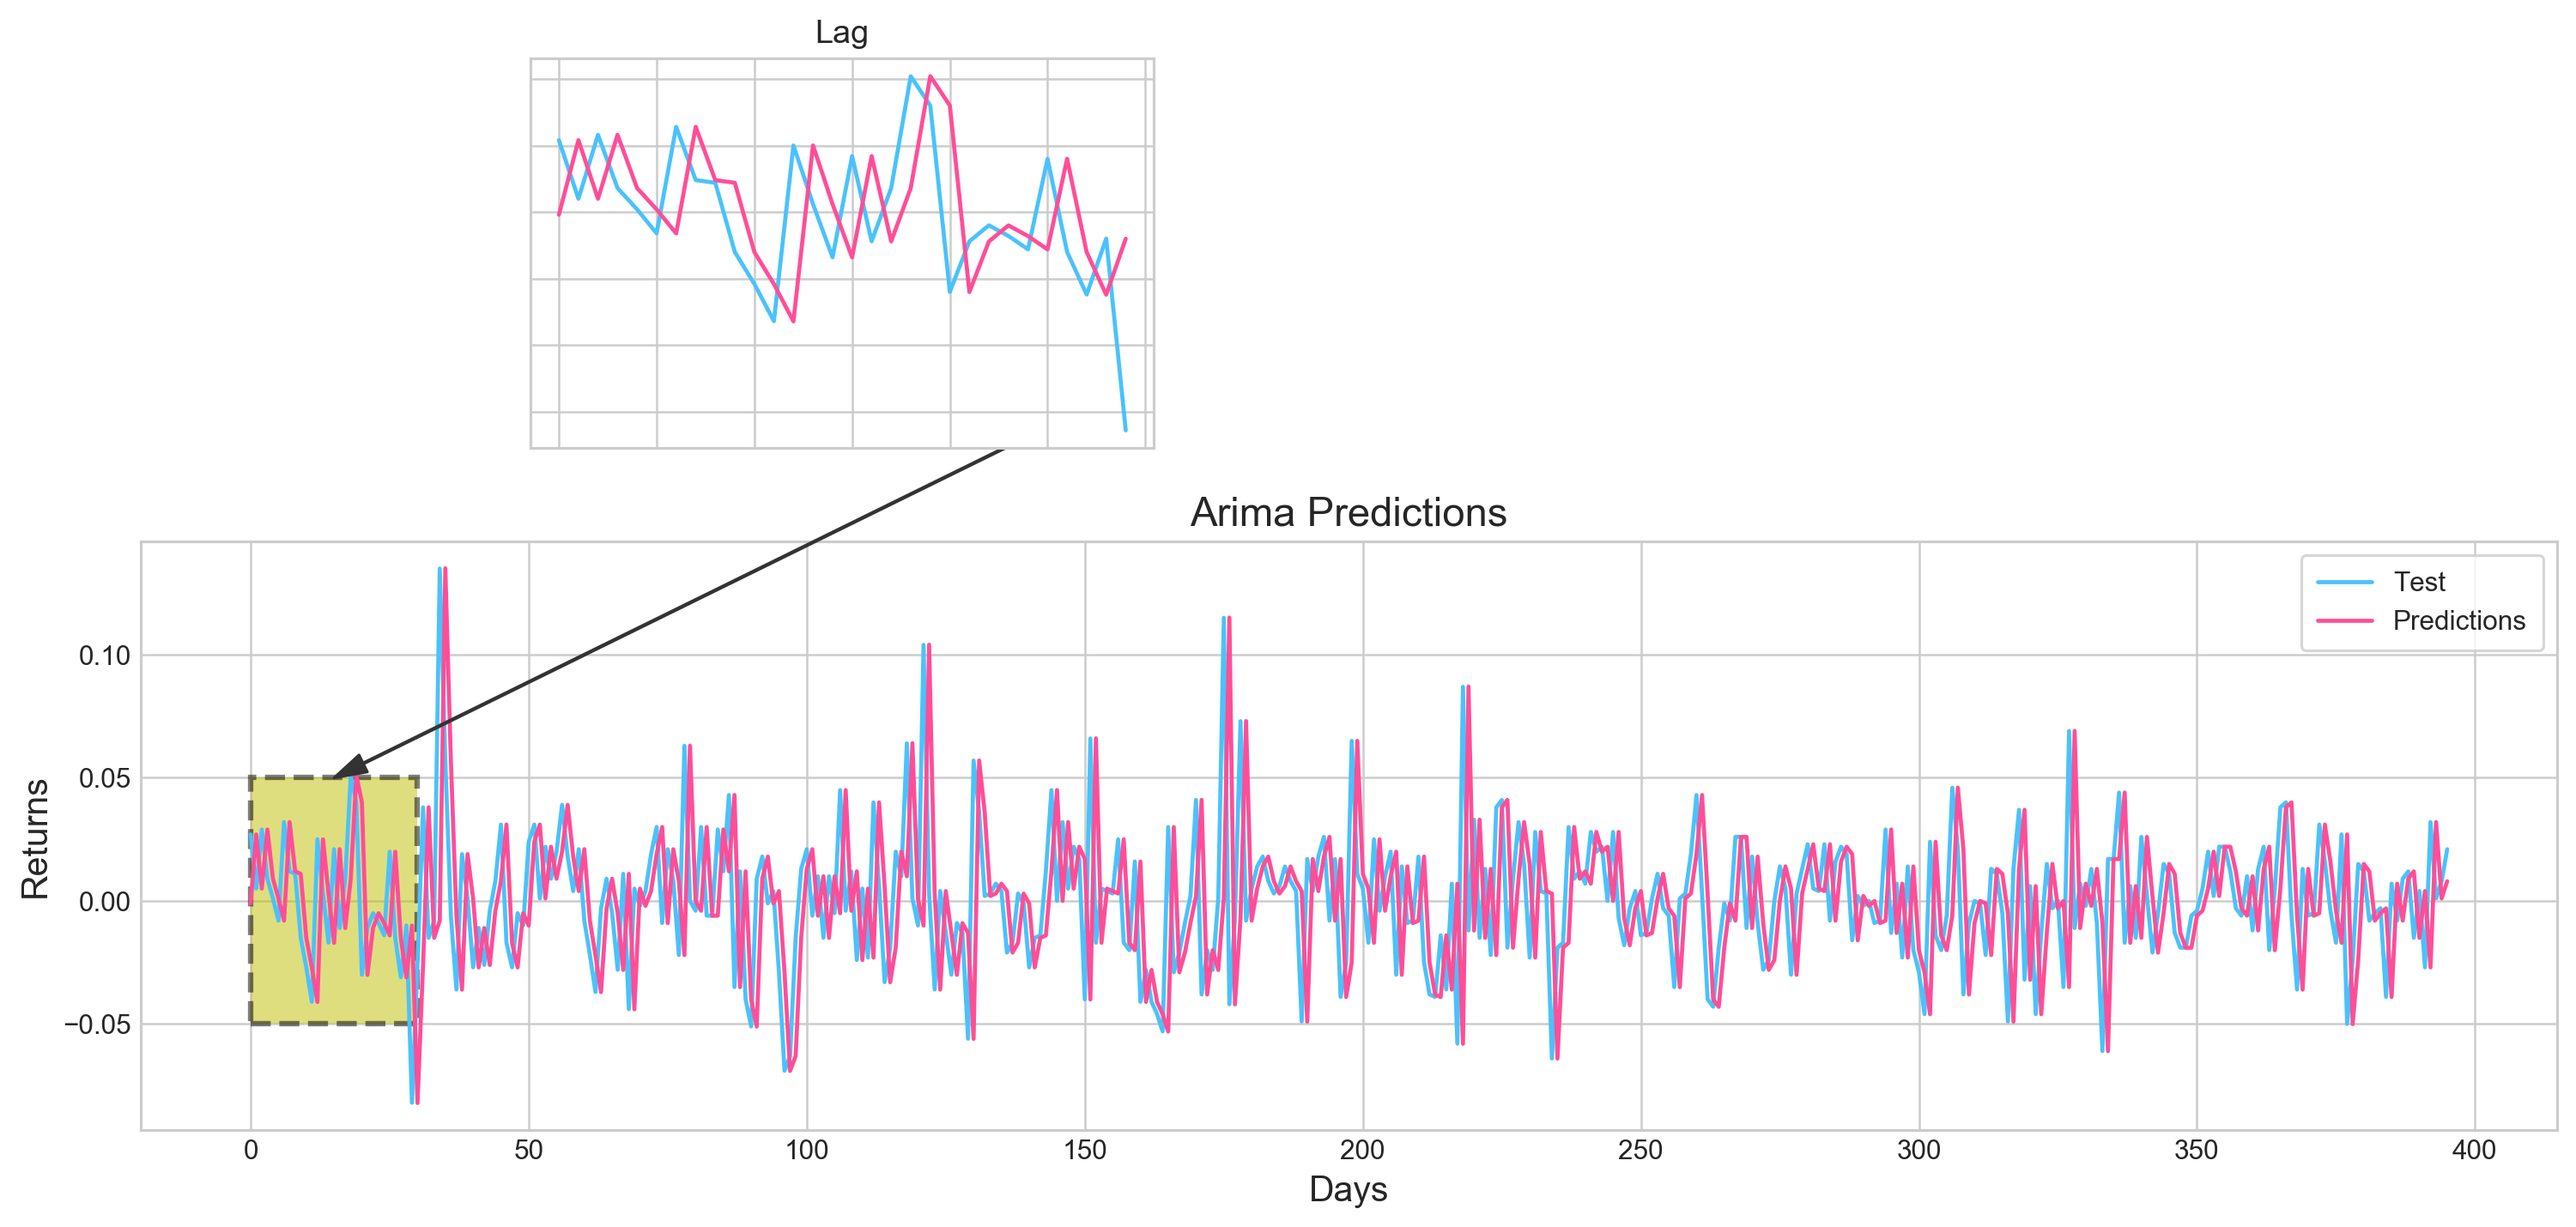

In [14]:
# https:/onepagecode.substack.com
fig = plt.figure(figsize=(16,4))
plt.plot(test, label='Test', color='#4ac2fb')
plt.plot(all_predictions[(0,1,0)], label='Predictions', color='#ff4e97')
plt.legend(frameon=True, loc=1, ncol=1, fontsize=10, borderpad=.6)
plt.title('Arima Predictions', fontSize=15)
plt.xlabel('Days', fontSize=13)
plt.ylabel('Returns', fontSize=13)

plt.annotate('',
             xy=(15, 0.05), 
             xytext=(150, .2), 
             fontsize=10, 
             arrowprops={'width':0.4,'headwidth':7,'color':'#333333'}
            )
ax = fig.add_subplot(1, 1, 1)
rect = patches.Rectangle((0,-.05), 30, .1, ls='--', lw=2, facecolor='y', edgecolor='k', alpha=.5)
ax.add_patch(rect)

plt.axes([.25, 1, .2, .5])
plt.plot(test[:30], color='#4ac2fb')
plt.plot(all_predictions[(0,1,0)][:30], color='#ff4e97')
plt.tick_params(axis='both', labelbottom=False, labelleft=False)
plt.title('Lag')
plt.show()

This code is used to plot a graph displaying the test data and the predicted data for stock prices. It creates a figure with a specific size, then plots the test data and the predictions on the graph. It adds legends, a title, and labels to the graph.   It also includes an annotation with an arrow on the graph to indicate a specific point. Additionally, it adds a patch in the form of a rectangle to highlight a specific region on the graph.  Lastly, it creates a smaller subplot within the main plot to show a zoomed-in view of the test and predicted data for the first 30 days. The subplot has no axis labels and is titled "Lag". The graph is then displayed.

### Histogram

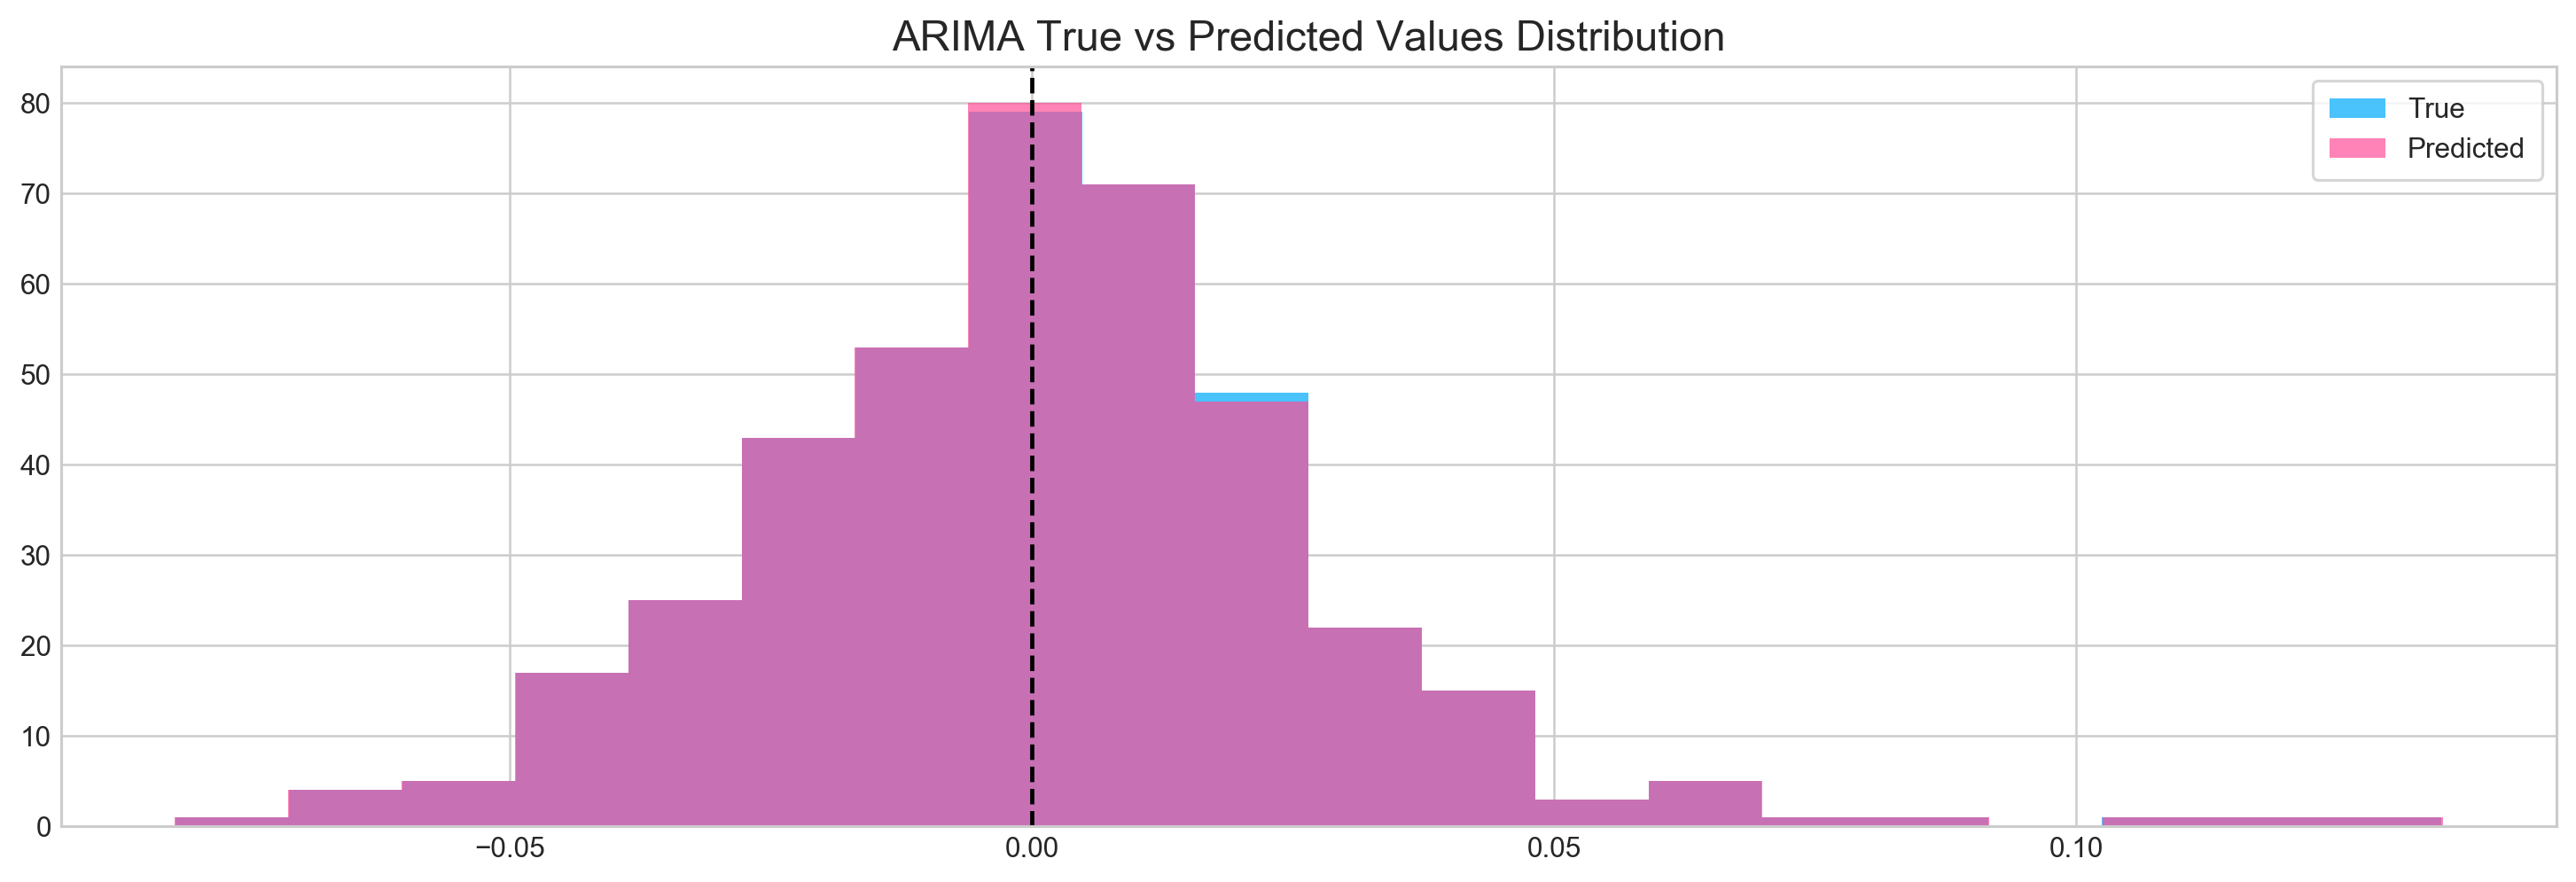

In [16]:
# https:/onepagecode.substack.com
plt.figure(figsize=(16,5))
plt.hist(stocks['tsla'][1900:2300].reset_index().Return, bins=20, label='True', facecolor='#4ac2fb')
plt.hist(all_predictions[(0,1,0)], bins=20, label='Predicted', facecolor='#ff4e97', alpha=.7)
plt.axvline(0, c='k', ls='--')
plt.title('ARIMA True vs Predicted Values Distribution', fontSize=15)
plt.legend(frameon=True, loc=1, ncol=1, fontsize=10, borderpad=.6)
plt.show()

This code generates a histogram plot comparing the distribution of true stock returns ('tsla') and the predicted stock returns. The data used for the histogram is a subset of the 'tsla' stock returns from index 1900 to 2300. The true stock returns are plotted in blue, while the predicted stock returns are plotted in pink with some transparency. A vertical dashed line at 0 is also plotted. The title of the plot is 'ARIMA True vs Predicted Values Distribution', and a legend is included to differentiate between the true and predicted values. Finally, the plot is displayed.

### Interpreting Results

In [18]:
# https:/onepagecode.substack.com
test_binary = functions.binary(stocks['tsla'][1900:2300].reset_index().Return)
train_binary = functions.binary(all_predictions[(0,1,0)])
tn, fp, fn, tp = confusion_matrix(test_binary, train_binary).ravel()
accuracy = accuracy_score(test_binary, train_binary)

print("True positive and Negative: {}".format((tp + tn)))
print("False Positive and Negative: {}".format((fp + fn)))
print("Accuracy: {:.1f}%".format(accuracy*100))

True positive and Negative: 203
False Positive and Negative: 193
Accuracy: 51.3%


This code is performing stock prediction using machine learning. The first two lines of code create binary variables for the test and train datasets. Then, the confusion matrix is calculated using the test and train variables, and the values for true negatives (tn), false positives (fp), false negatives (fn), and true positives (tp) are retrieved from the confusion matrix. The accuracy score is then calculated using the test and train variables. Finally, the code prints the sum of true positive and negative predictions, the sum of false positive and negative predictions, and the accuracy percentage.

# 3. Sentiment Analysis

Idea here is to use news sentiment to predict returns next day

In [19]:
# https:/onepagecode.substack.com
tesla_headlines = pd.read_csv('data/tesla_headlines.csv', index_col='Date')

This code imports the pandas library and uses it to read a CSV file called 'tesla_headlines.csv'. The file contains headlines related to the stock market performance of the company Tesla. The 'index_col' parameter is set to 'Date', which means that the 'Date' column in the CSV file will be set as the index for the resulting dataframe.

In [20]:
# https:/onepagecode.substack.com
tesla = stocks['tsla'].join(tesla_headlines.groupby('Date').mean().Sentiment)

This code assigns the result of joining the 'tsla' stock data with the average sentiment for each date from a dataset called 'tesla_headlines' to the variable 'tesla'. The purpose of this code is to combine the stock data with the corresponding sentiment data for Tesla, which can be used for stock prediction using machine learning techniques.

In [21]:
# https:/onepagecode.substack.com
tesla.fillna(0, inplace=True)

This code is a part of stock prediction using machine learning. It is specifically related to the Tesla stock. The `fillna()` function is being used on the `tesla` variable. `fillna()` is a function used to replace missing values in a dataframe or series. In this case, the missing values are being replaced with the number 0. The `inplace=True` parameter ensures that the changes are made directly to the `tesla` dataframe without creating a new object.

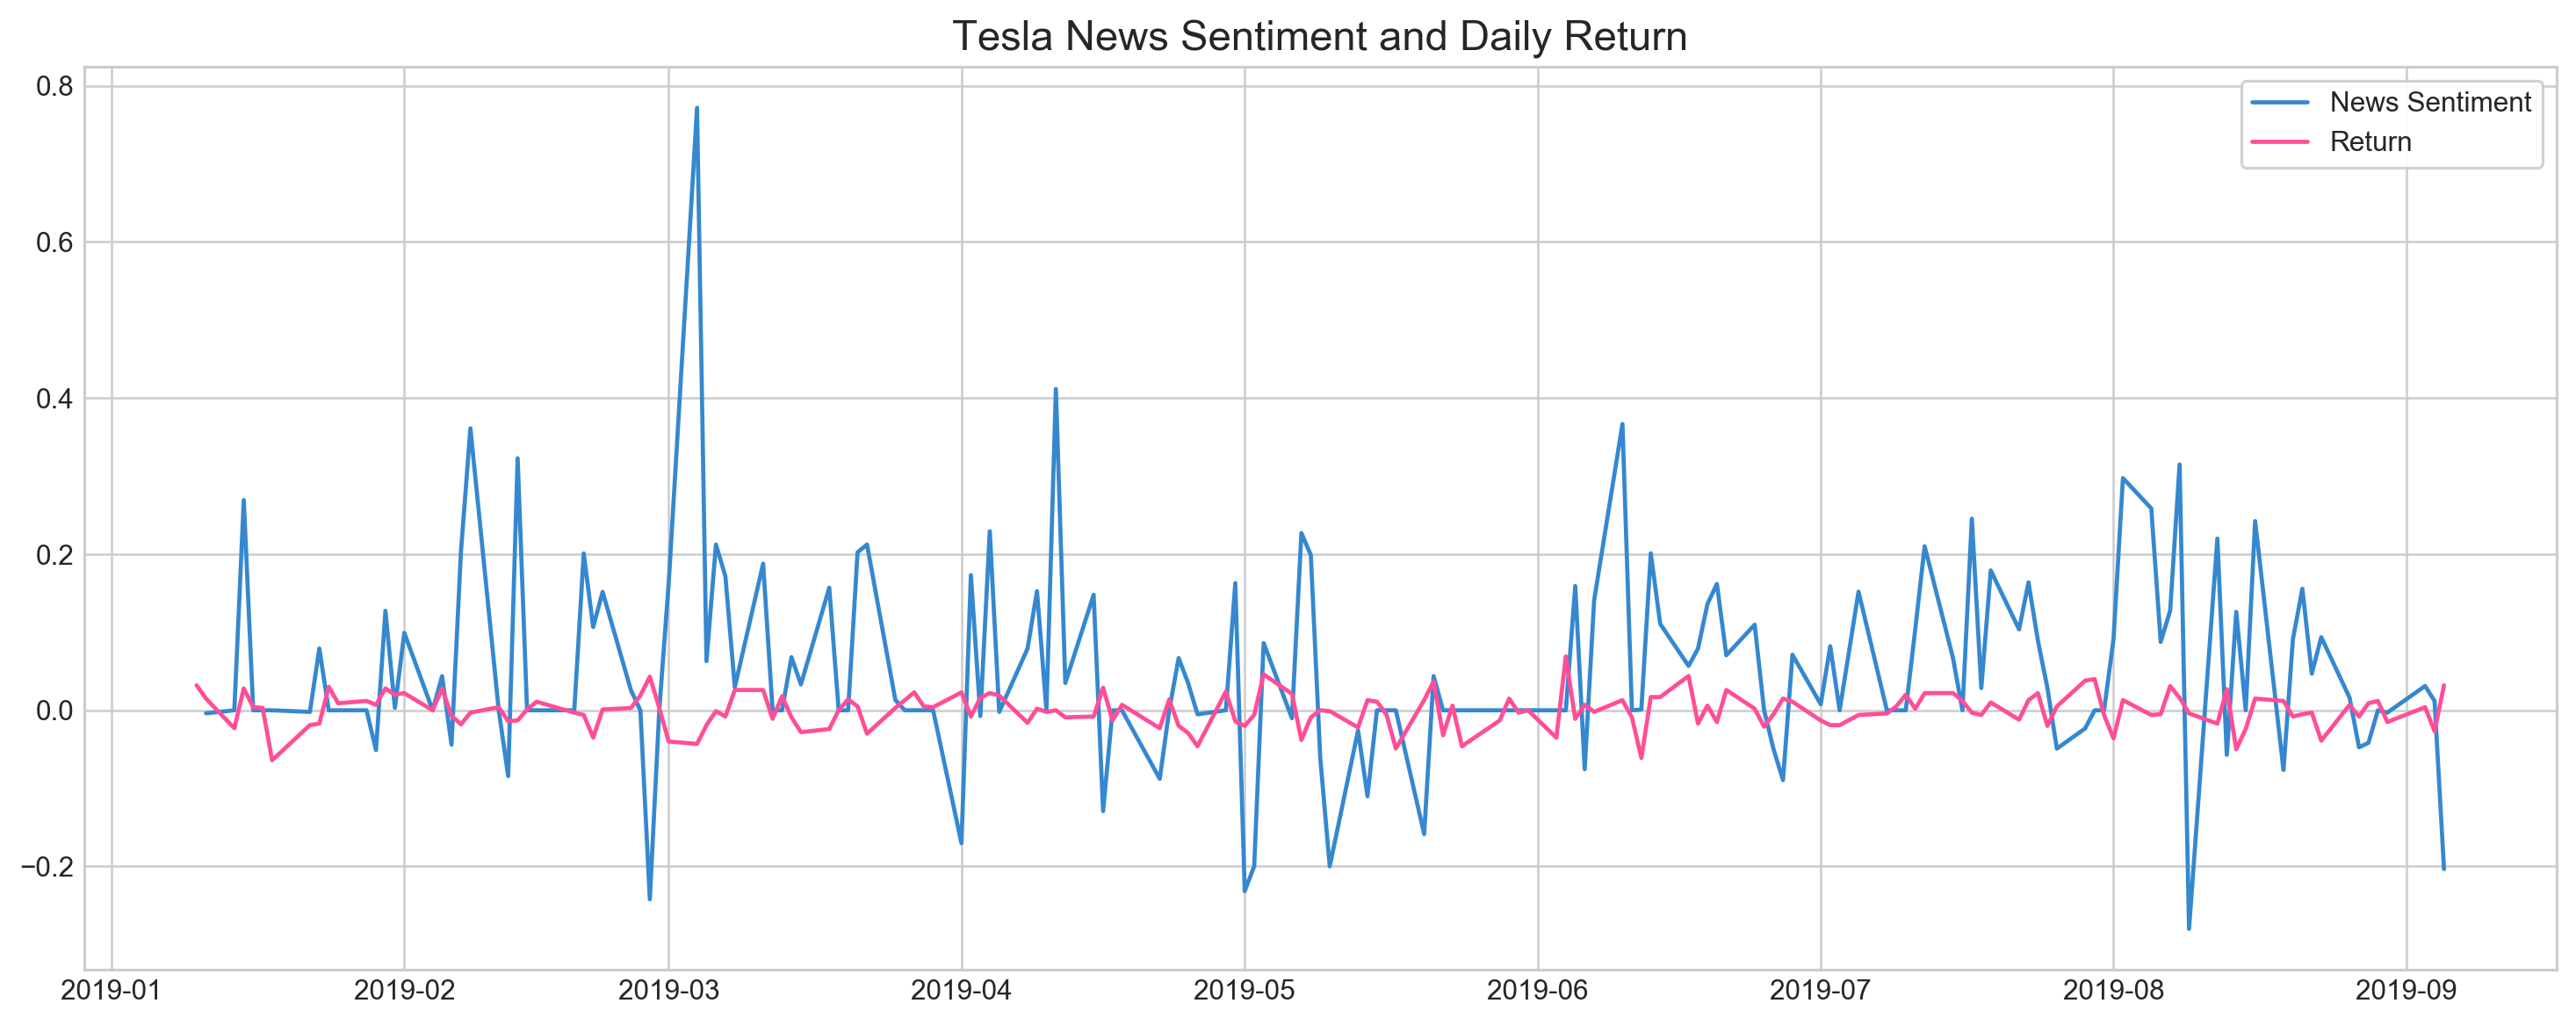

In [22]:
# https:/onepagecode.substack.com
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(16,6))
plt.plot(tesla.loc['2019-01-10':'2019-09-05'].Sentiment.shift(1), c='#3588cf', label='News Sentiment')
plt.plot(tesla.loc['2019-01-10':'2019-09-05'].Return, c='#ff4e97', label='Return')
plt.legend(frameon=True, fancybox=True, framealpha=.9, loc=1)
plt.title('Tesla News Sentiment and Daily Return', fontSize=15)
plt.show()

This code creates a line plot that compares the sentiment of news about Tesla stock to the daily return of the stock. It uses the 'seaborn-whitegrid' style and sets the figure size to 16x6. The plot shows the sentiment data from the '2019-01-10' to '2019-09-05' shifted by one day, represented by the blue line labeled 'News Sentiment'. It also shows the daily return data for the same period, represented by the pink line labeled 'Return'. The plot includes a legend, a title, and is displayed using the plt.show() function.

In [23]:
# https:/onepagecode.substack.com
pd.DataFrame({
    'Sentiment': tesla.loc['2019-01-10':'2019-09-05'].Sentiment.shift(1), 
    'Return': tesla.loc['2019-01-10':'2019-09-05'].Return}).corr()

Sentiment    Return
Sentiment   1.000000 -0.139348
Return     -0.139348  1.000000

This code creates a Pandas DataFrame that computes the correlation between two columns in a dataset. The 'Sentiment' column is created by shifting the 'Sentiment' column of a dataset called 'tesla' by one index. The 'Return' column is created by selecting the 'Return' column of the 'tesla' dataset within a specified date range. The function 'corr()' is then applied to the DataFrame to calculate the correlation between these two columns.

### Conclusion

Correlation between news and price movement is negative. Prices moves in the opposite direction, which is wrong. Positive news suppose to drive prices up, not the opposite way.

# 4. Features selection with XGBoost

XGBoost will be used here to extract important features that will be used for neural networks. This might help to improve model accuracy and boost training. Traning will be performed on scaled `Tesla` dataset.

In [24]:
# https:/onepagecode.substack.com
scaled_tsla = functions.scale(stocks['tsla'], scale=(0,1))

This code creates a scaled version of the 'tsla' stock data using a scaling function. The function used is called 'scale' from the 'functions' module. The scale range for the data is specified as (0,1), meaning that the scaled values will range from 0 to 1. The resulting scaled data is stored in the variable 'scaled_tsla'.

In [25]:
# https:/onepagecode.substack.com
X = scaled_tsla[:-1]
y = stocks['tsla'].Return.shift(-1)[:-1]

This code first assigns the variable 'X' to a subset of the 'scaled_tsla' data, discarding the last item in the dataset. It then assigns the variable 'y' to the 'Return' column of the 'tsla' stocks dataframe, with a value shift of -1, and drops the last item from the resulting series.

In [26]:
# https:/onepagecode.substack.com
xgb = XGBClassifier()
xgb.fit(X[1500:], y[1500:])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

This code creates an instance of the XGBClassifier class, which is a classifier algorithm used for machine learning. The fit() method is then called on the XGBClassifier instance, passing in a subset of the input data X and corresponding labels y. This fit() method trains the classifier on the provided data, allowing it to learn patterns and make predictions.

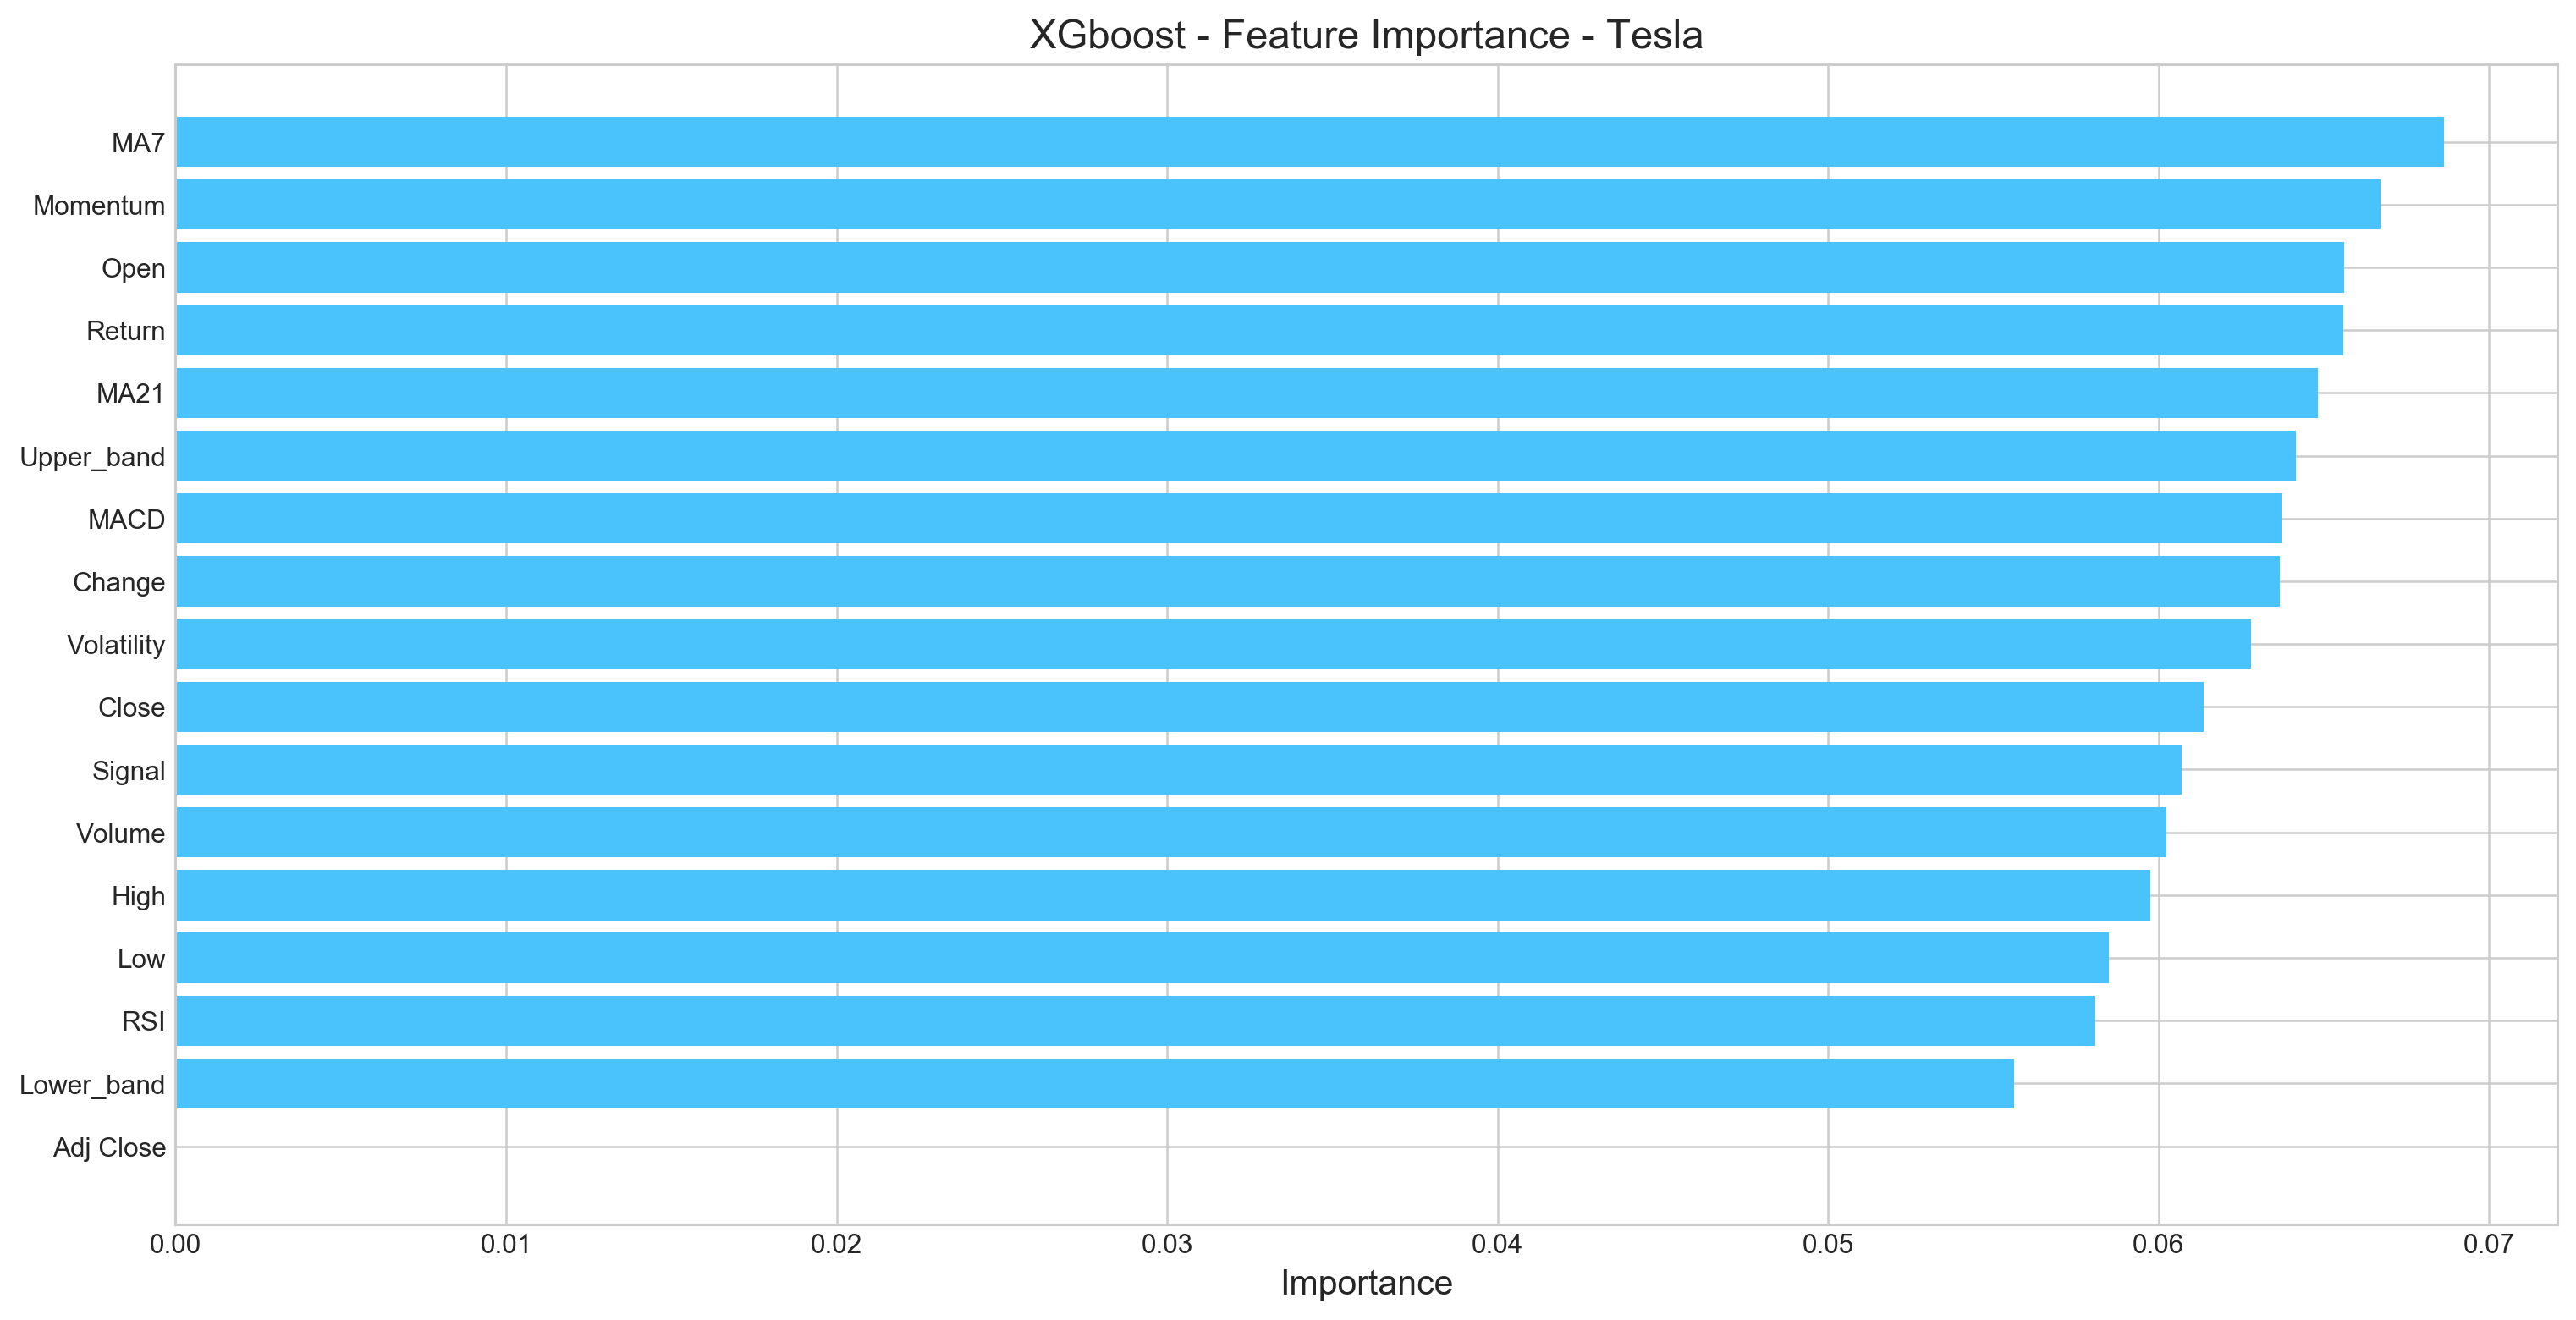

In [27]:
# https:/onepagecode.substack.com
important_features = pd.DataFrame({
                                    'Feature': X.columns, 
                                    'Importance': xgb.feature_importances_}) \
                                    .sort_values('Importance', ascending=True)

plt.figure(figsize=(16,8))
plt.style.use('seaborn-whitegrid')
plt.barh(important_features.Feature, important_features.Importance, color="#4ac2fb")
plt.title('XGboost - Feature Importance - Tesla', fontSize=15)
plt.xlabel('Importance', fontSize=13)
plt.show()

This code calculates and plots the feature importance of a machine learning model trained for stock prediction.   First, it creates a DataFrame called "important_features" that contains two columns: "Feature" (which represents the names of the features used in the model) and "Importance" (which represents the importance of each feature in the model as calculated by the XGBoost algorithm).  Next, it sorts the rows of the "important_features" DataFrame in ascending order based on the "Importance" column.  Then, it creates a bar plot using the sorted "important_features" DataFrame. The horizontal bars represent the feature names, while the lengths of the bars represent the importance of each feature. The color of the bars is set to "#4ac2fb". The title of the plot is set as 'XGboost - Feature Importance - Tesla', with a font size of 15. The x-axis label is set as 'Importance', with a font size of 13.  Finally, it displays the plot.

# 5. Deep Neural Networks

## Preparing Data

In [28]:
# https:/onepagecode.substack.com
n_steps = 21
scaled_tsla = functions.scale(stocks['tsla'], scale=(0,1))

X_train, \
y_train, \
X_test, \
y_test = functions.split_sequences(
                        
    scaled_tsla.to_numpy()[:-1], 
    stocks['tsla'].Return.shift(-1).to_numpy()[:-1], 
    n_steps, 
    split=True, 
    ratio=0.8
)

This code defines a variable `n_steps` as 21. It then scales the 'tsla' column from the 'stocks' dataframe using the `scale` function. The scaled 'tsla' data is then used to split sequences into training and testing sets.  The training set, denoted as `X_train` and `y_train`, is created by taking the scaled 'tsla' data (excluding the last element) and the shifted 'Return' values from the 'stocks' dataframe (excluding the last element) using the `split_sequences` function. The last argument of `split_sequences` is set to `split=True` and a ratio of 0.8, indicating that the sequences should be split into training and testing sets with a ratio of 80% for training.  The testing set, denoted as `X_test` and `y_test`, is created similarly, but using the remaining 20% of the data.  Overall, this code prepares the data for stock prediction using machine learning by scaling the input data and splitting it into training and testing sets.

## 5.1 LSTM Network

In [27]:
# https:/onepagecode.substack.com
keras.backend.clear_session()

n_steps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dense(10))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

This code is implementing a stock prediction model using machine learning.   The code starts by clearing the Keras session.   Then, it defines the number of time steps and features in the training data.   Next, it creates a Sequential model. The model architecture consists of two LSTM (Long Short-Term Memory) layers. The first LSTM layer has 100 units and uses the ReLU activation function. It returns sequences of outputs. The input shape is determined by the number of time steps and features. The second LSTM layer has 50 units and also uses the ReLU activation function. It does not return sequences of outputs.   After the LSTM layers, there are two Dense layers. The first Dense layer has 10 units. The second Dense layer has 1 unit.   The model is compiled using the Adam optimizer, mean squared error (mse) as the loss function, and mean absolute error (mae) as the metric.

In [28]:
# https:/onepagecode.substack.com
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 100)           47200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 77,921
Trainable params: 77,921
Non-trainable params: 0
_________________________________________________________________


The code snippet `model.summary()` is used to generate a summary of a machine learning model. This summary provides information about the layers in the model, the number of parameters in each layer, and the total number of trainable parameters in the model. It also shows the shape of the input and output tensors for each layer. This summary is useful for understanding the structure and complexity of the model, and it can help in troubleshooting and optimizing the model during the development process.

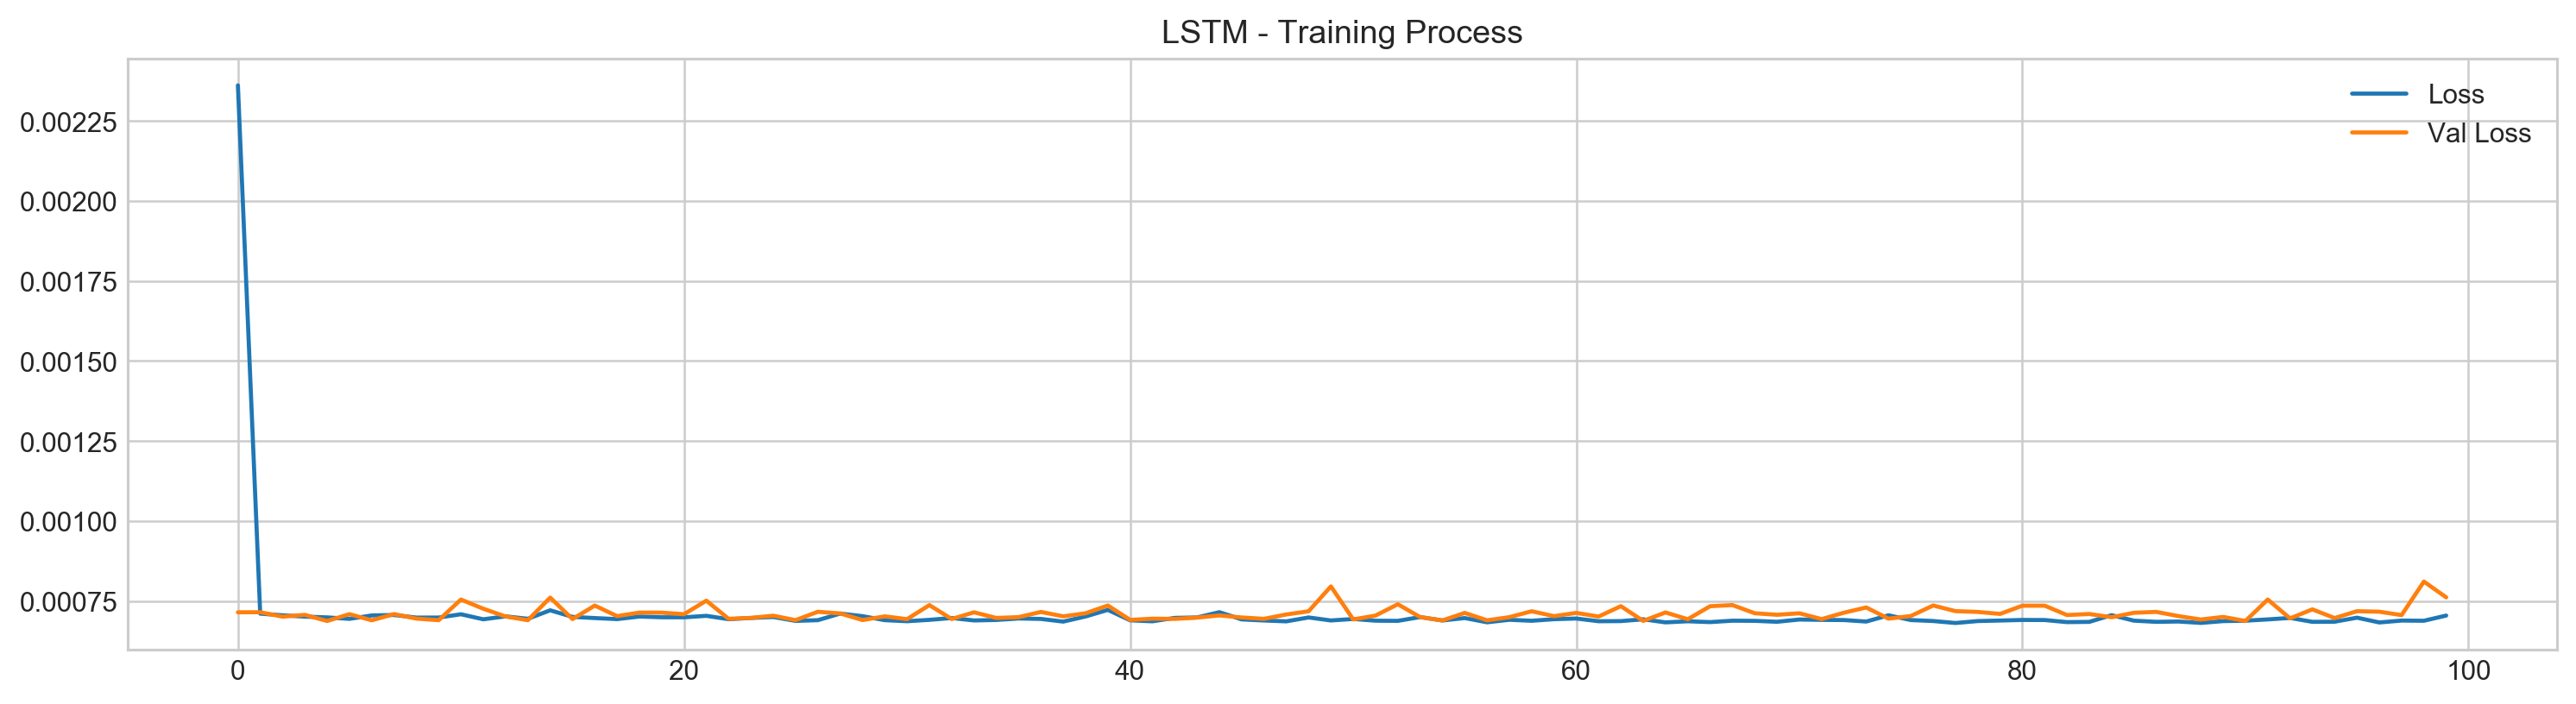

In [29]:
# https:/onepagecode.substack.com
model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=[X_test, y_test], use_multiprocessing=True)

plt.figure(figsize=(16,4))
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Val Loss')
plt.legend(loc=1)
plt.title('LSTM - Training Process')
plt.show()

The code is fitting a machine learning model to X_train and y_train data for 100 epochs. It is using the X_test and y_test data for validation during the training process. The use_multiprocessing flag indicates that multiprocessing should be used during training.  After training the model, the code plots the loss and validation loss values over the training process. The loss value represents the difference between the predicted and actual values during training. The validation loss value represents the difference between the predicted and actual values during validation. The plot is displayed in a figure with a title "LSTM - Training Process".

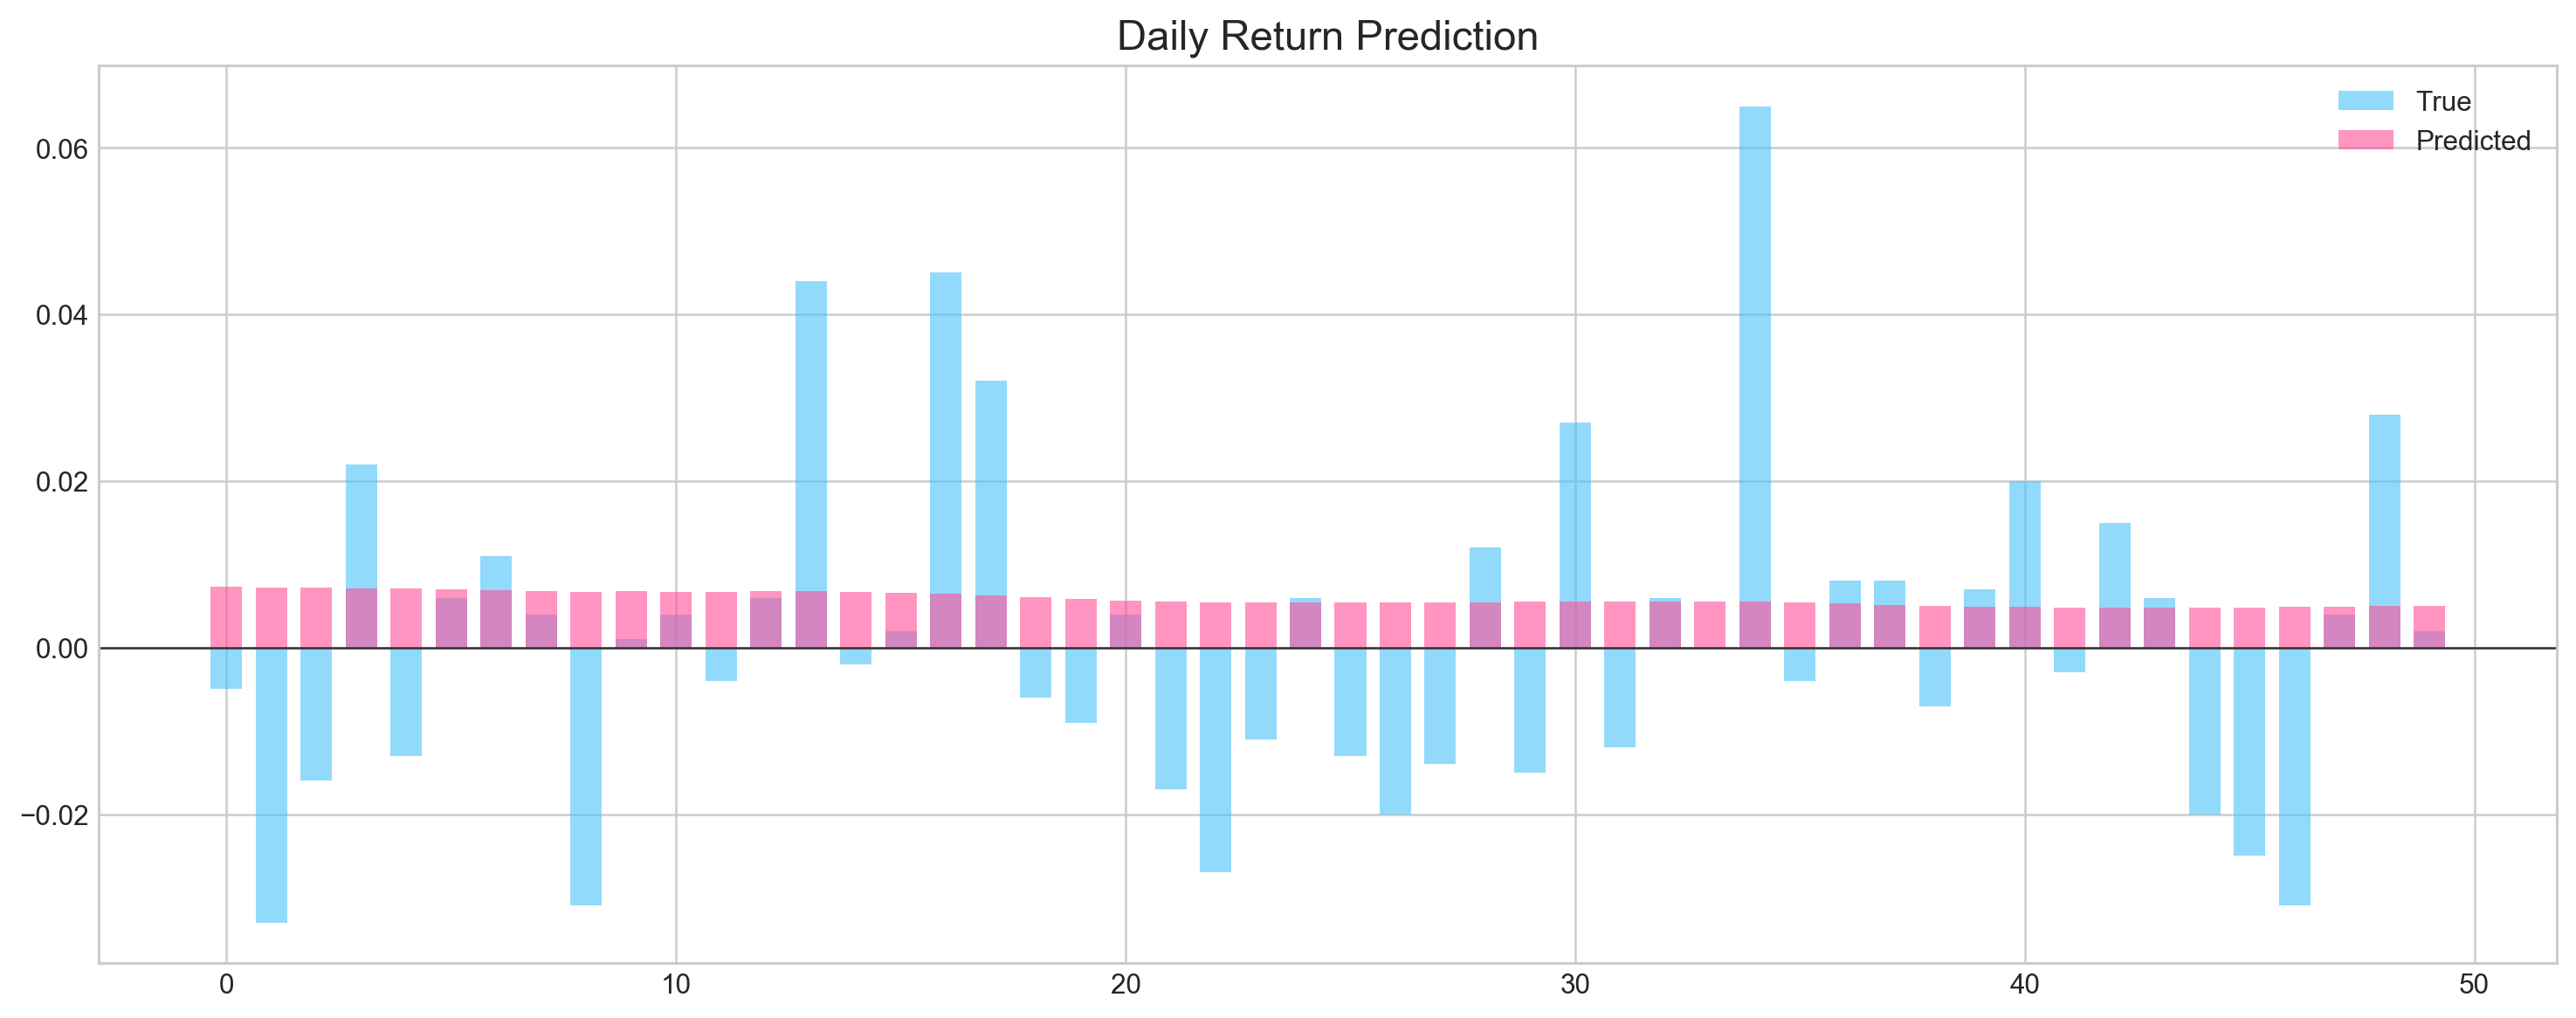

MSE: 0.0004098401772089238
Accuracy: 52%


In [30]:
# https:/onepagecode.substack.com
pred, y_true, y_pred = functions.evaluation(
                    X_test, y_test, model, random=False, n_preds=50, 
                    show_graph=True)

This code is used for evaluating the performance of a machine learning model for stock prediction.   The variables `X_test` and `y_test` are the test data, which consist of features and corresponding target values, respectively.   The `model` variable represents the machine learning model that has been trained on historical stock data.   The `functions.evaluation()` function is called to evaluate the model's performance. It takes several arguments: the test data (`X_test` and `y_test`), the trained model (`model`), a boolean parameter `random` indicating whether to use random predictions or not, and the number of predictions to make (`n_preds`).   The function returns three values: `pred`, `y_true`, and `y_pred`. `pred` represents the predicted values of the target variable, `y_true` represents the true values of the target variable from the test data, and `y_pred` represents the predicted values of the target variable based on the model's predictions.   Additionally, the function also plots a graph to visualize the actual and predicted values of the target variable, indicated by the `show_graph` parameter set to `True`.

### Conclusion

Network wasn't able to pick up the underlying patterns. Prediction is roughly 50%, which is same as random guess

## 5.2 Convolutional Network

In [31]:
# https:/onepagecode.substack.com
keras.backend.clear_session()

n_steps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()

model.add(Conv1D(filters=20, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(5, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

This code is setting up a neural network for stock prediction using machine learning.   First, the code clears the previous session of the Keras backend.  Then, it determines the number of time steps and features in the training data.  Next, it creates a sequential model.  The model consists of a convolutional layer with 20 filters and a kernel size of 2, using the ReLU activation function. The input shape of this layer is determined by the number of time steps and features.  After that, a max pooling layer with a pool size of 2 is added to reduce the dimensionality.  Following the pooling layer, a flatten layer is added to transform the output into a 1D vector.  Next, a dense layer with 5 units and ReLU activation function is added.  Finally, an output layer with a single unit is added.  The model is then compiled with the Adam optimizer, mean squared error (mse) loss function,
and mse metric.

In [32]:
# https:/onepagecode.substack.com
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 20)            700       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 20)            0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1005      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 1,711
Trainable params: 1,711
Non-trainable params: 0
_________________________________________________________________


The code snippet `model.summary()` is used to print a summary of a machine learning model. This summary provides a concise overview of the model's architecture, including the number of trainable parameters and the shape of each layer in the model. It allows us to see the structure and complexity of the model and is often used for debugging and model analysis purposes.

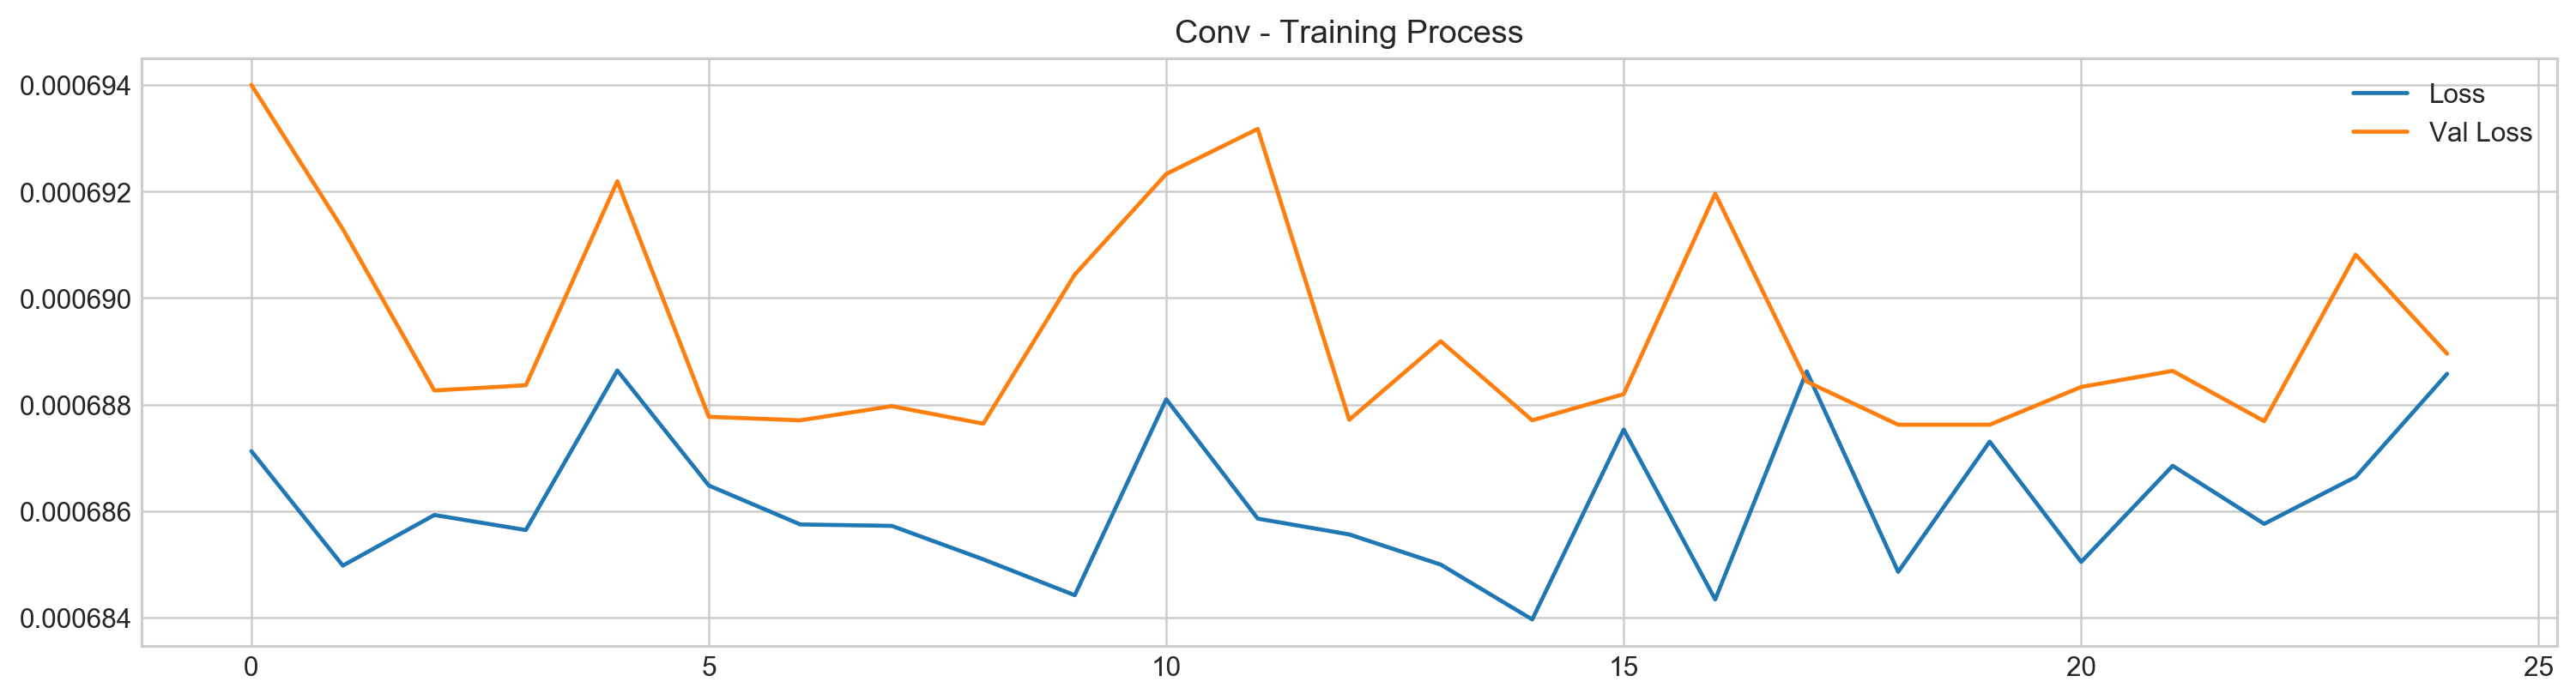

In [34]:
# https:/onepagecode.substack.com
model.fit(X_train, y_train, epochs=25, verbose=0, validation_data=[X_test, y_test], use_multiprocessing=True)

plt.figure(figsize=(16,4))
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Val Loss')
plt.legend(loc=1)
plt.title('Conv - Training Process')
plt.show()

The code is fitting a machine learning model to the training data. The model is being trained for 25 epochs, and the training process is not being displayed (verbose=0). The validation data is being used to validate the model's performance during training, and multiprocessing is being used for faster training.  After the model is trained, the code plots the training and validation loss over the epochs. The loss is a metric that measures the performance of the model - a lower loss indicates better performance. The plot helps visualize how the model's performance improves or converges over the training process. The plot is displayed using the matplotlib library.

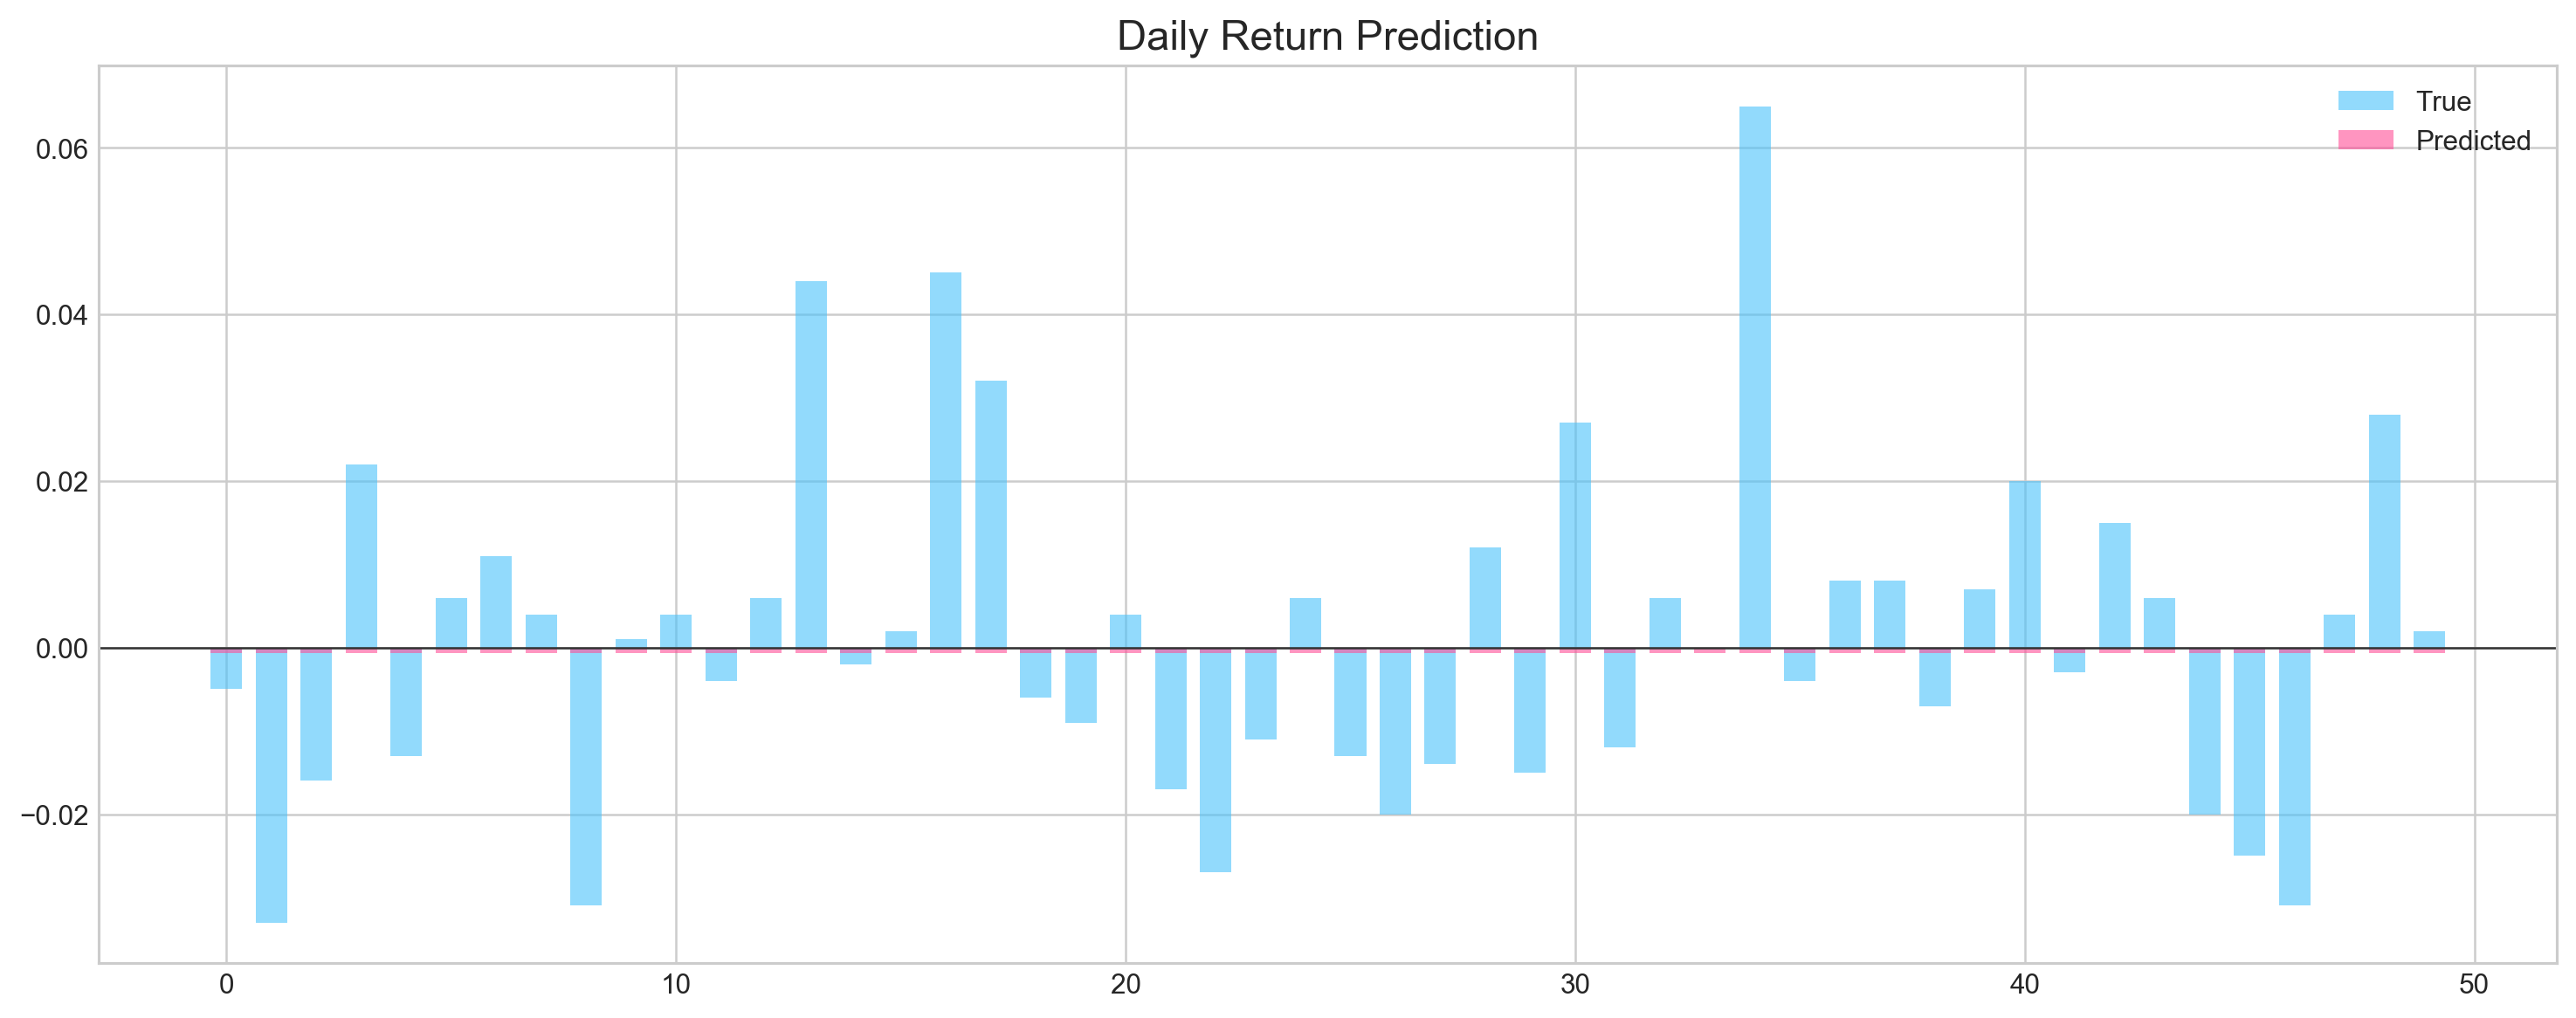

MSE: 0.00039170174676989575
Accuracy: 46%


In [35]:
# https:/onepagecode.substack.com
pred, y_true, y_pred = functions.evaluation(
                    X_test, y_test, model, random=False, n_preds=50, 
                    show_graph=True)

This code is calling the function `evaluation` from the `functions` module with the arguments `X_test`, `y_test`, `model`, `random=False`, `n_preds=50`, and `show_graph=True`.   The function `evaluation` is likely responsible for evaluating the performance of a machine learning model for stock prediction. It takes the test data `X_test` and `y_test`, the model, and some other optional parameters as input.   The code then assigns the output of the function to three variables: `pred`, `y_true`, and `y_pred`. These variables probably store the predictions made by the model (`pred`), the true values of the stock prices (`y_true`), and the predicted values of the stock prices (`y_pred`). The use of these variables may depend on the specific implementation and further code.

### Conclusion

Network wasn't able to pick up the underlying patterns. Prediction is roughly 50%, which is same as random guess

## 5.3 Combined Stocks Data

Training on 18 different stocks.

In [36]:
# https:/onepagecode.substack.com
all_stocks = pd.concat(stocks,ignore_index=True)

This code is concatenating multiple data frames, specifically stock data frames, into one single data frame called "all_stocks". The "pd.concat()" function is used to concatenate the data frames. The parameter "stocks" represents a list of the stock data frames that are being concatenated. The parameter "ignore_index=True" indicates that the resulting data frame should have a new index, ignoring the index values from the original data frames.

In [37]:
# https:/onepagecode.substack.com
scaled_all = functions.scale(all_stocks, scale=(0,1))

n_steps = 21
X_train, y_train, X_test, y_test = functions.split_sequences(
                        scaled_all.to_numpy()[:-1], 
                        all_stocks['Return'].shift(-1).to_numpy()[:-1], n_steps, split=True, ratio=0.8)

The given code is part of a stock prediction machine learning model.   The first line scales the 'all_stocks' data using the 'scale' function from the 'functions' module. The data is scaled using a scale range of 0 to 1.  The next line initializes the number of steps as 21.  The third line prepares the training and testing datasets. The 'split_sequences' function from the 'functions' module is used to split the data. It takes in the scaled data (excluding the last row), the shifted 'Return' values of the 'all_stocks' data (excluding the last row), the number of steps, a split flag (True), and a ratio of 0.8 as parameters. It returns the training and testing features (X_train, X_test) and labels (y_train, y_test) based on the given ratio.

In [40]:
# https:/onepagecode.substack.com
keras.backend.clear_session()

n_steps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()
model.add(Conv1D(filters=500, kernel_size=10, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=10))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse')

This code sets up a convolutional neural network (CNN) model for stock price prediction.   The `keras.backend.clear_session()` function clears any existing models or layers in memory.  The variables `n_steps` and `n_features` are set to the number of time steps and features in the input data, respectively.  The `model` variable is initialized as a sequential model, which means that the layers will be added in a sequential manner.  The model includes a `Conv1D` layer with 500 filters, a kernel size of 10, and the ReLU activation function. This layer processes the input data using convolution, which is useful for capturing patterns in sequential data.  A `MaxPooling1D` layer with a pool size of 10 follows the convolutional layer. This layer reduces the dimensionality of the data, which helps to extract the most important features.  The `Flatten` layer is added to convert the pooled feature maps into a single continuous vector.  The model then includes two `Dense` layers with 500 and 100 neurons respectively, both using the ReLU activation function. These fully connected layers help to learn more complex patterns and relationships in the data.  Finally, a `Dense` layer with 1 neuron and the sigmoid activation function is added as the output layer. This layer predicts the stock price movement as a binary classification problem (increase or decrease).  The model is compiled with the Adam optimizer and the mean squared error (MSE) loss function, which is commonly used for regression problems.

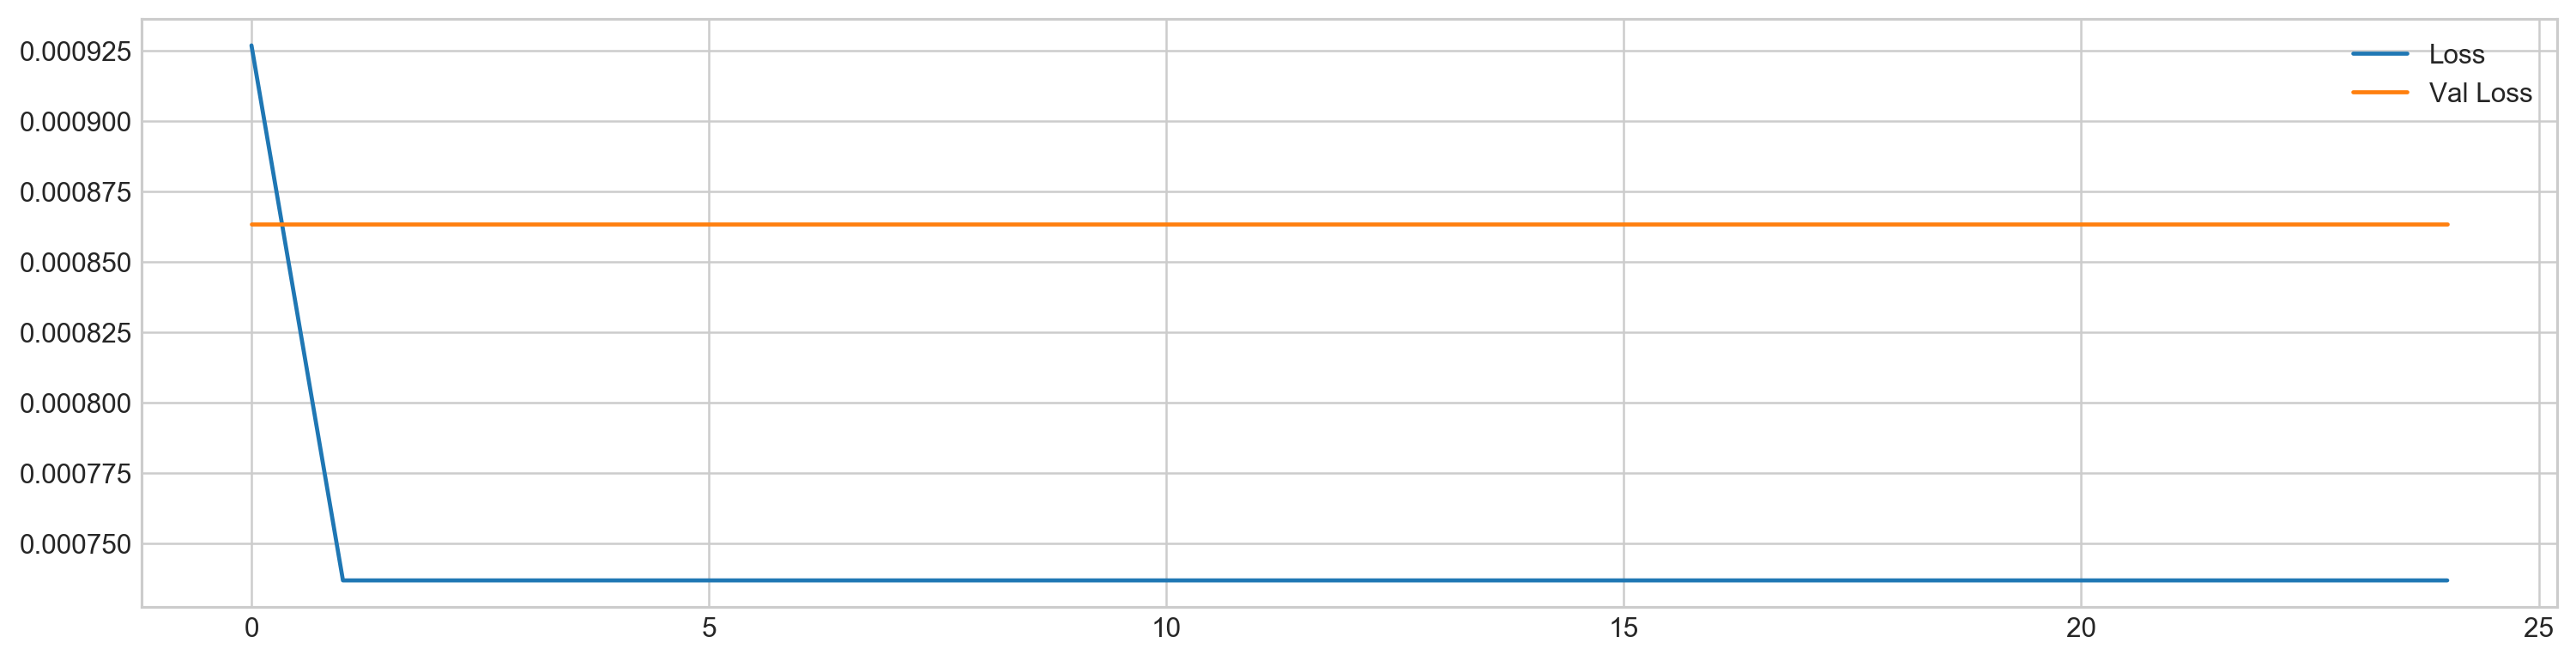

In [41]:
# https:/onepagecode.substack.com
model.fit(X_train, y_train, epochs=25, verbose=0, validation_data=[X_test, y_test], use_multiprocessing=True)

plt.figure(figsize=(16,4))
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Val Loss')
plt.legend(loc=1)
plt.show()

This code trains a machine learning model for stock prediction. The model is trained using the `X_train` and `y_train` data for 25 epochs. The training process is done in parallel using multiprocessing.   After training, the code creates a figure with a plot to visualize the loss and validation loss of the model over the epochs. The loss values represent the difference between the predicted and actual values during training, while the validation loss measures the model's performance on a separate set of data (X_test and y_test). The plot helps to evaluate the model's training progress and identify if overfitting or underfitting occurs.

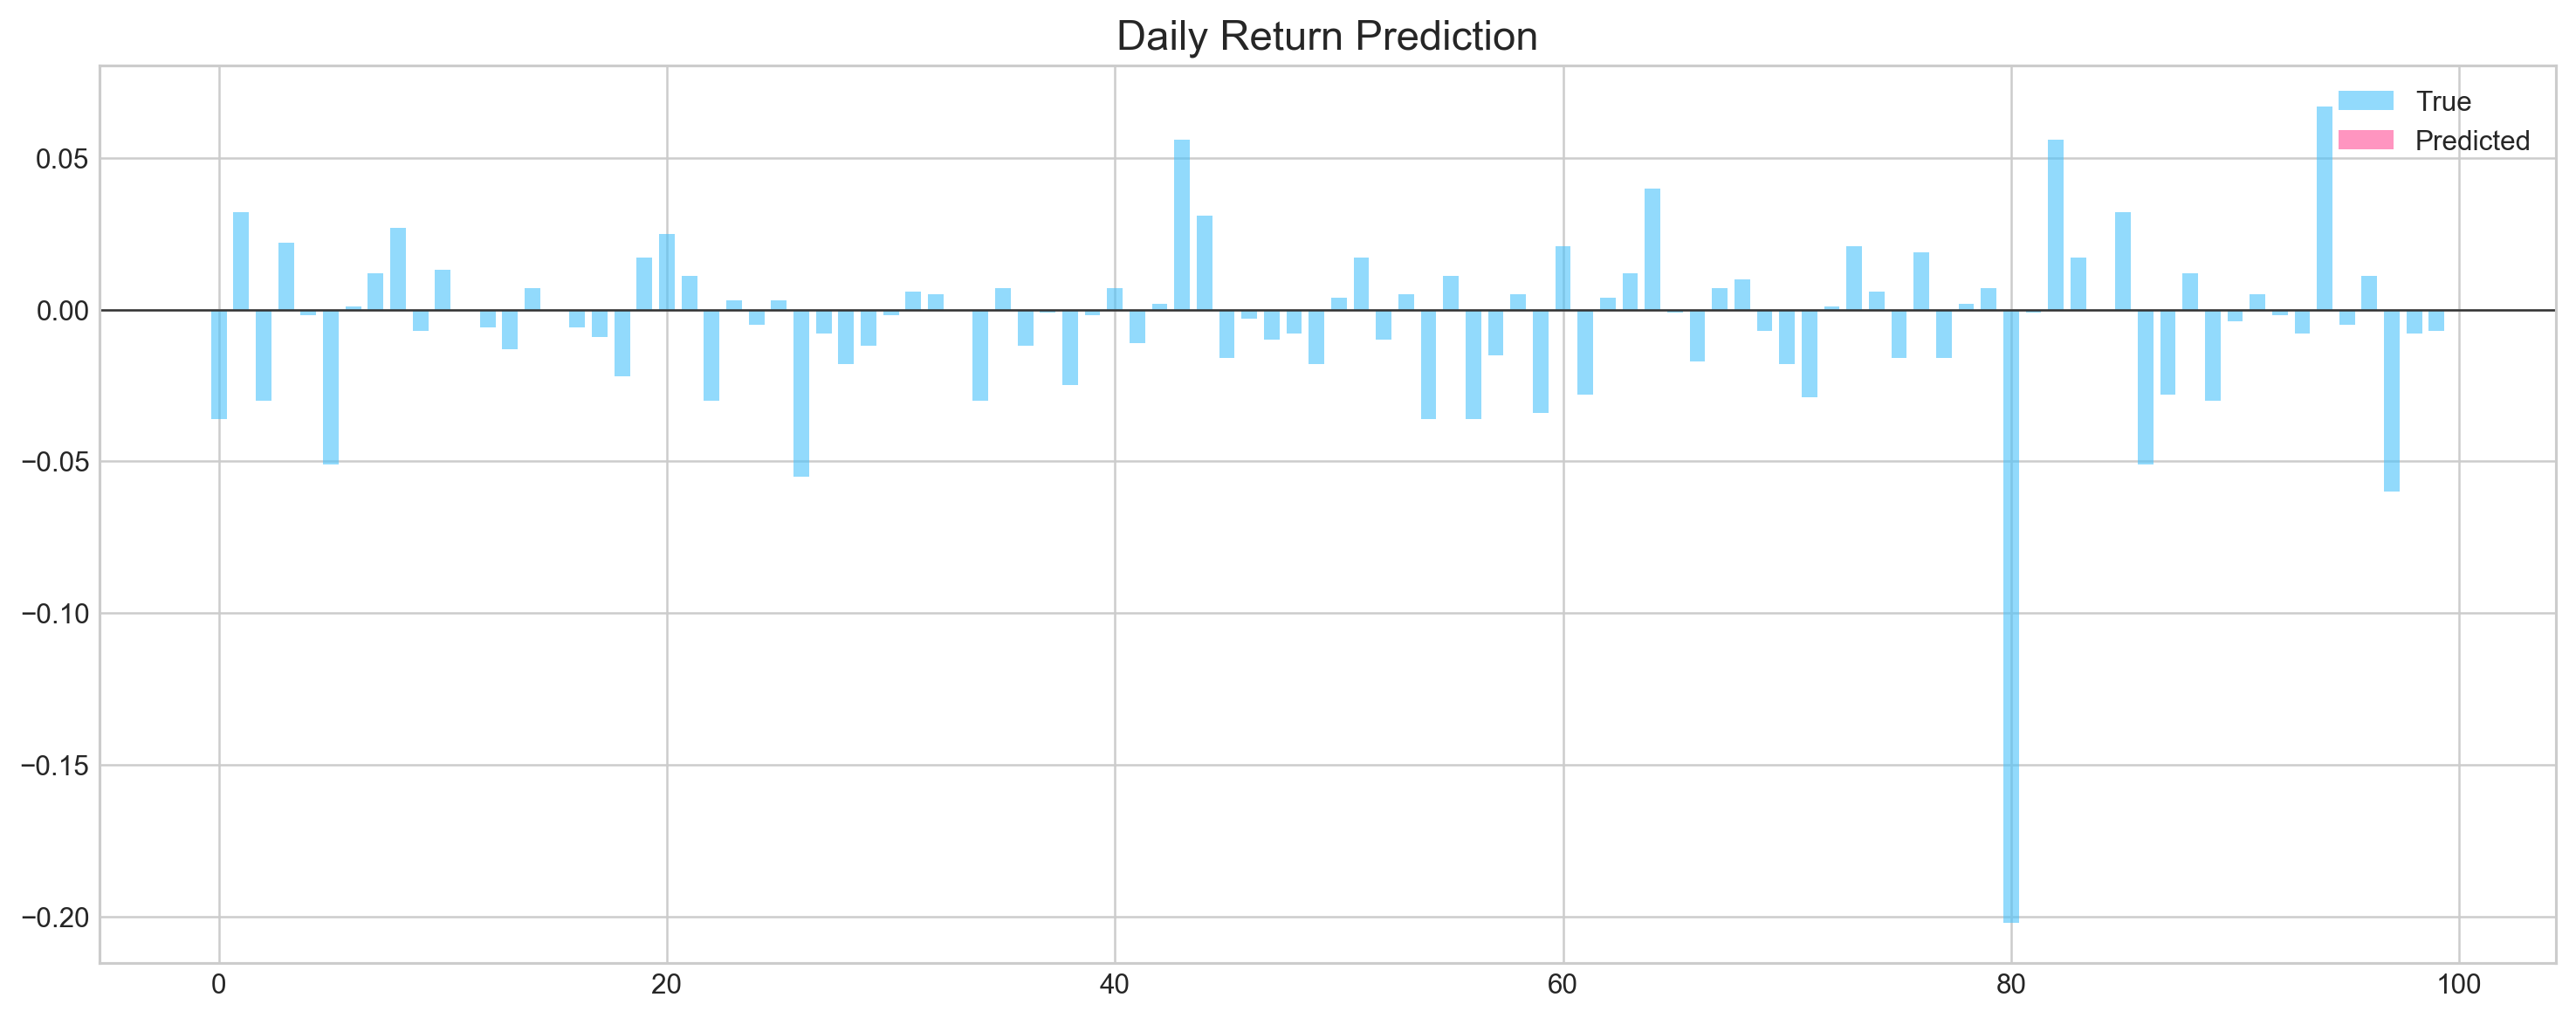

MSE: 0.0008933400166195816
Accuracy: 0%


In [42]:
# https:/onepagecode.substack.com
pred, y_true, y_pred = functions.evaluation(
                    X_test, y_test, model, random=True, n_preds=100, 
                    show_graph=True)

This code is performing evaluation in a stock prediction model using machine learning. The "functions.evaluation" function is being called with several parameters: the test data (X_test and y_test), the model, a random flag set to True, the number of predictions to generate (n_preds = 100), and a flag to show a graph.   The function will then generate predictions (pred) using the provided test data and model. It will compare the predicted values (y_pred) with the true values (y_true) from the test data. The evaluation process will also include some randomization and it will create a graph to visualize the comparison.

## 5.4 Bayesian Optimization

In [43]:
# https:/onepagecode.substack.com
def create_model(d1, d2, filters, pool, kernel):
    keras.backend.clear_session()
        
    d1 = int(d1)
    d2 = int(d2)
    filters = int(filters)
    kernel = int(kernel)
    pool = int(pool)
    
    n_steps = X_train.shape[1]
    n_features = X_train.shape[2]
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel, activation='relu', input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=pool))
    model.add(Flatten())
    model.add(Dense(d1, activation='relu'))
    model.add(Dense(d2, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    model.fit(X_train, y_train, epochs=4, verbose=0, validation_data=[X_test, y_test], use_multiprocessing=True)
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[1]

This code defines a function called "create_model" that creates a machine learning model for stock prediction. The function takes in several parameters, including the number of filters, the pool size, and the kernel size. It then converts these parameters to integers.  The function then determines the number of time steps and features in the training dataset. It creates a sequential model using the Keras library, adding a 1D convolutional layer, a max pooling layer, and flatten layer. It then adds two dense layers with ReLU activation functions, and a final dense layer with a linear activation function.  The model is compiled with the Adam optimizer, mean squared error loss function, and mean squared error metric. It is trained on the training dataset for 4 epochs, using the validation dataset for validation. The training is done in parallel using multiprocessing.  After training, the model is evaluated on the test dataset, and the evaluation score (mean squared error) is returned.

In [48]:
# https:/onepagecode.substack.com
def bayesian_optimization():    

    pbounds = {
        'filters': (1, 10), 
        'd1': (160, 250), 
        'd2': (10, 40), 
        'kernel': (2,10), 
        'pool': (2, 10)
    }

    optimizer = BayesianOptimization(
        f = create_model,
        pbounds = pbounds,
        random_state = 1,
        verbose = 2
    )
    optimizer.maximize(init_points=5, n_iter=5)
    print(optimizer.max)

This code is performing a Bayesian optimization for stock prediction using machine learning.   In the beginning, a dictionary called `pbounds` is defined, which specifies the ranges or bounds for the hyperparameters that will be optimized. The hyperparameters include 'filters', 'd1', 'd2', 'kernel', and 'pool', and each hyperparameter has its own range of possible values.  Next, an instance of the `BayesianOptimization` class is created and assigned to the variable `optimizer`. This class takes in several parameters, including the objective function `create_model` that will be optimized, the specified `pbounds`, a random state for reproducibility, and a verbosity level for logging.  The `maximize()` method is called on the `optimizer` object, with the arguments `init_points=5` and `n_iter=5`. This method performs the Bayesian optimization, initializing with 5 random points and iterating 5 times to find the optimum hyperparameters.  Finally, the optimized result is printed using the `print(optimizer.max)` statement.

In [49]:
# https:/onepagecode.substack.com
n_steps = 21
scaled_tsla = functions.scale(stocks['tsla'], scale=(0,1))

X_train, \
y_train, \
X_test, \
y_test = functions.split_sequences(
                        
    scaled_tsla.to_numpy()[:-1], 
    stocks['tsla'].Return.shift(-1).to_numpy()[:-1], 
    n_steps, 
    split=True, 
    ratio=0.8
)

This code sets the number of steps to 21 and scales the 'tsla' stock data using a scaling function.   It then splits the scaled 'tsla' data into X_train, y_train, X_test, and y_test using a function called 'split_sequences'. The X_train and y_train data are used for training a machine learning model, while the X_test and y_test data are used for testing the model. The split is done using a ratio of 0.8, meaning 80% of the data is used for training and 20% for testing. The split is based on a predefined number of steps (21 in this case).

In [50]:
# https:/onepagecode.substack.com
bayesian_optimization()

|   iter    |  target   |    d1     |    d2     |  filters  |  kernel   |   pool    |
-------------------------------------------------------------------------------------
|  1        |  0.000697 |  197.5    |  31.61    |  1.001    |  4.419    |  3.174    |
|  2        |  0.000688 |  168.3    |  15.59    |  4.11     |  5.174    |  6.311    |
|  3        |  0.000687 |  197.7    |  30.56    |  2.84     |  9.025    |  2.219    |
|  4        |  0.000685 |  220.3    |  22.52    |  6.028    |  3.123    |  3.585    |
|  5        |  0.000697 |  232.1    |  39.05    |  3.821    |  7.539    |  9.011    |
|  6        |  0.000905 |  249.9    |  10.57    |  9.351    |  4.988    |  9.367    |
|  7        |  0.000687 |  160.9    |  10.15    |  9.038    |  9.98     |  9.433    |
|  8        |  0.000688 |  249.5    |  10.1     |  9.981    |  8.354    |  9.82     |
|  9        |  0.000689 |  160.3    |  39.92    |  8.524    |  7.485    |  8.883    |
|  10       |  0.000695 |  249.8    |  39.55    |  1.1

The code snippet is calling a function named "bayesian_optimization()". It is likely that this function utilizes the technique of Bayesian optimization. Bayesian optimization is a method used in machine learning for optimizing hyperparameters of models. It combines probability and statistics to efficiently search for the best hyperparameters based on an objective function, typically used in tasks like stock prediction.   However, without looking into the actual implementation of the "bayesian_optimization()" function, it is difficult to provide further details on the specific functionality and behavior of the code.

In [52]:
# https:/onepagecode.substack.com
n_steps = X_train.shape[1]
n_features = X_train.shape[2]
keras.backend.clear_session()
model = Sequential()
model.add(Conv1D(filters=9, kernel_size=5, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=9))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

This code initializes a neural network model for stock prediction using machine learning. It starts by determining the number of time steps and features in the input data. The Keras backend is cleared to remove any existing models.  The model is then created using the Sequential class from Keras. It consists of several layers. The first layer is a Conv1D layer with 9 filters, a kernel size of 5, and a ReLU activation function. It takes as input a 3D tensor with shape (n_steps, n_features).  Next, a MaxPooling1D layer with a pool size of 9 is added to the model. This layer reduces the dimensionality of the data.  A Flatten layer is then added to flatten the output from the previous layers into a 1D tensor.  Two Dense layers are added to the model. The first Dense layer has 250 units and a ReLU activation function. The second Dense layer has 10 units and a ReLU activation function.  Finally, a Dense layer with a single unit is added to the model. This is the output layer, as it predicts the stock price. The model is compiled with the Adam optimizer, mean squared error (MSE) as the loss function, and MSE as the metric for evaluation.

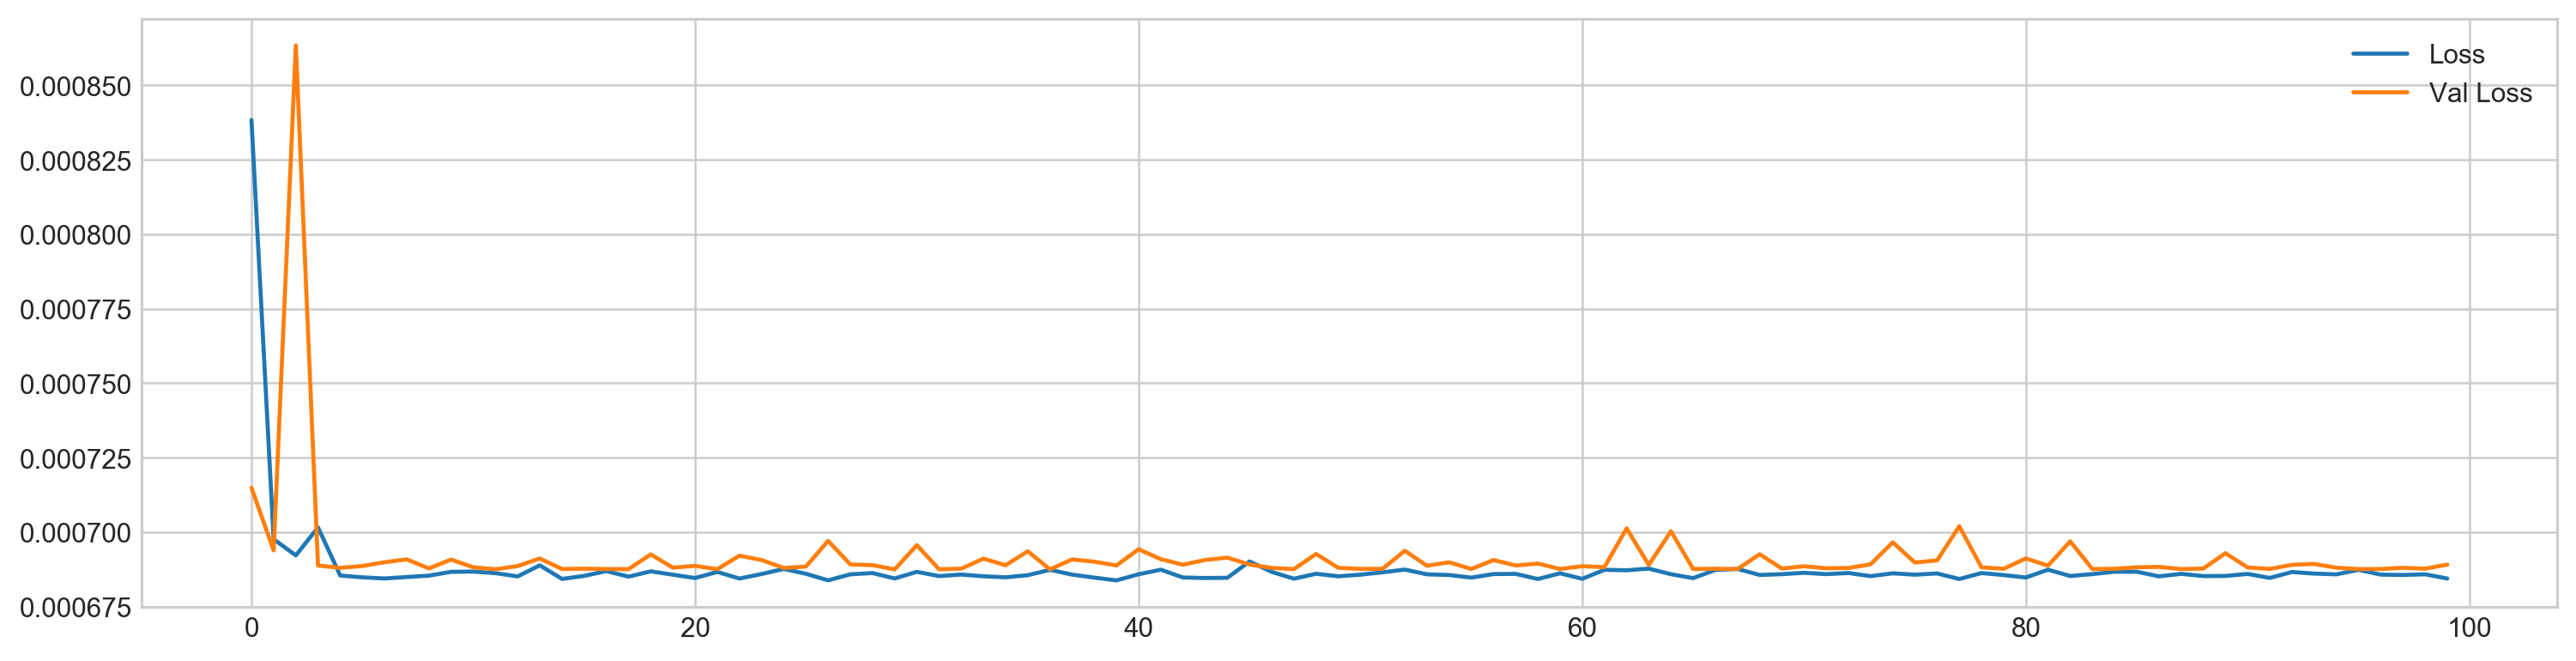

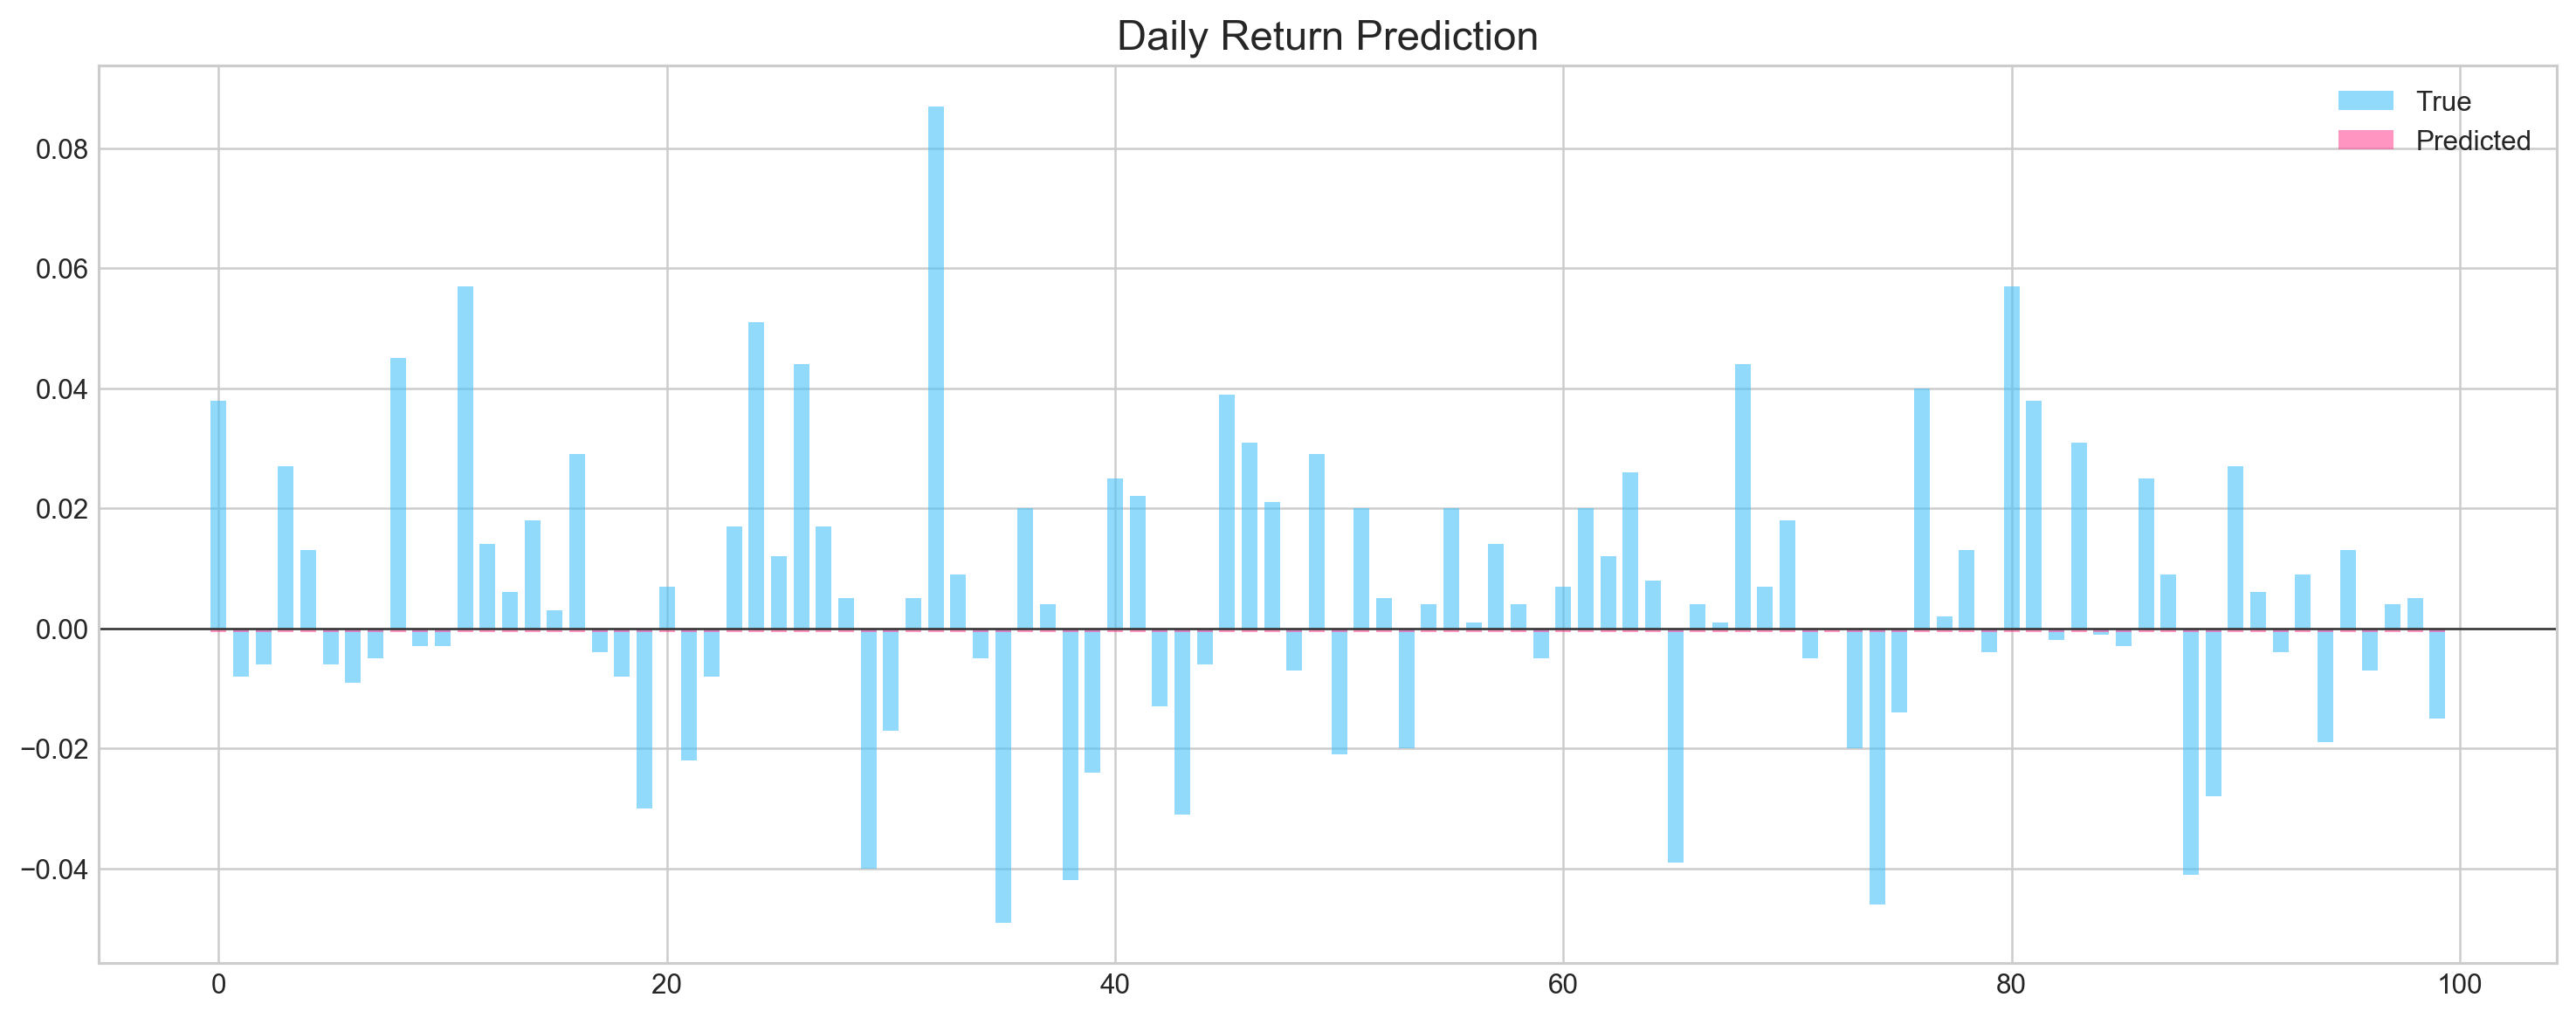

MSE: 0.0005993790584345679
Accuracy: 40%


In [53]:
# https:/onepagecode.substack.com
model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=[X_test, y_test], use_multiprocessing=True)

plt.figure(figsize=(16,4))
plt.plot(model.history.history['loss'], label='Loss')
plt.plot(model.history.history['val_loss'], label='Val Loss')
plt.legend(loc=1)
plt.show()

pred, y_true, y_pred = functions.evaluation(
                    X_test, y_test, model, random=True, n_preds=100, 
                    show_graph=True)

The code is fitting a machine learning model to training data, with 100 epochs (iterations), and it is not displaying any output during the training process. The model is then evaluated using the test data, and the evaluation results are plotted as a graph. The evaluation function used also generates some additional predictions and displays them as a graph.

### Conclusion

Bayesian optimization didn't improve accuracy. Results are similar to the previous networks.

# 6. Finding Similar Patterns

Hypothesis behind this idea is simple: can patterns (sequences) found train set be used to predict patterns in test set? Pattern is a sequence of daily stock returns presented as binary values (0 - if return is negative, 1 - if return is positive). Example of sequence: [0, 1, 1, 0, 1, 0, 0, 1, 0]. The process can be broken down into several steps:
1. Split data into train and test sets
2. Pick first pattern (with length of 9 days) from test set and collect similar patterns in train set
3. Compare 10th day of train patterns with 10th day of test pattern, save result
4. Repeat process for the rest of the patterns in test set

## Example

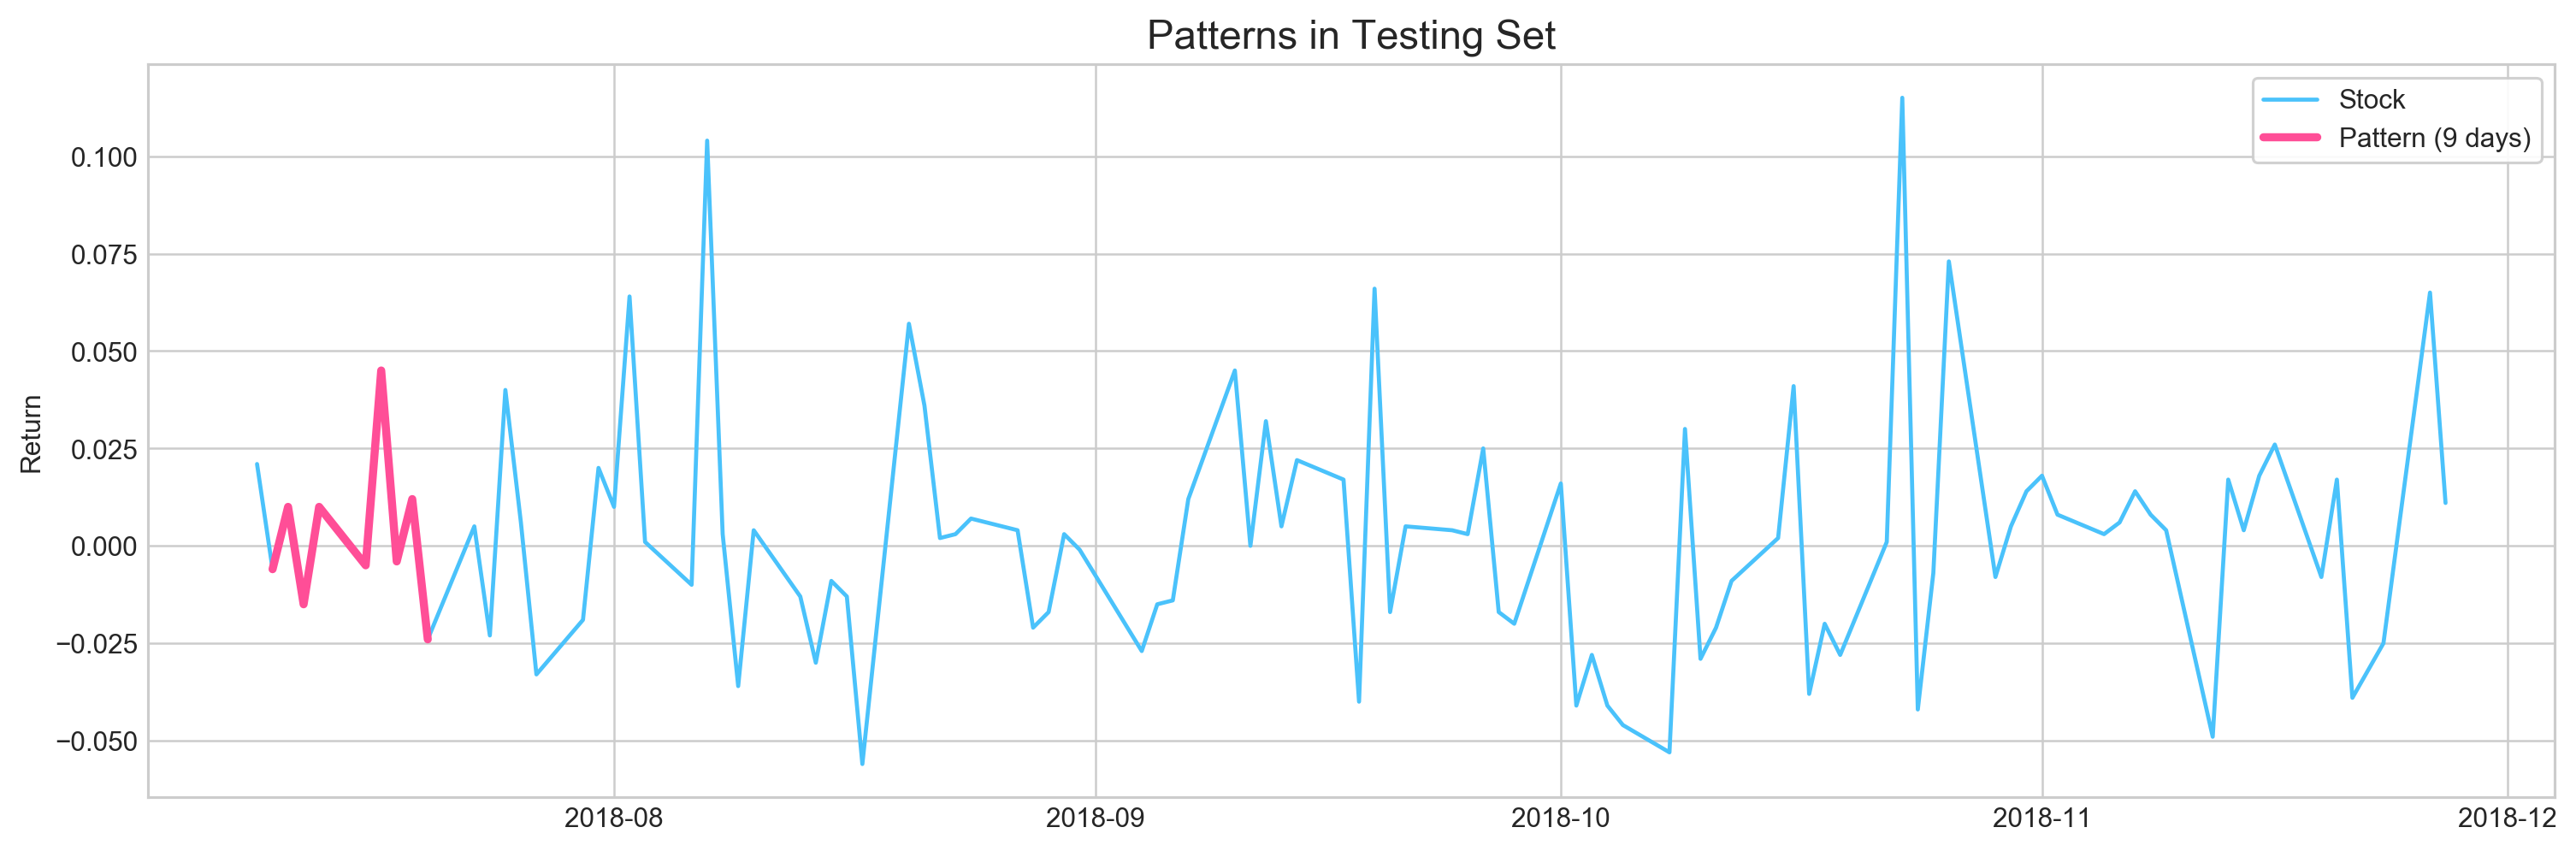

In [204]:
# https:/onepagecode.substack.com
plt.figure(figsize=(16,5))
plt.style.use('seaborn-whitegrid')
plt.plot(stocks['tsla'][2000:2100].Return, label='Stock', c='#4ac2fb')
plt.plot(stocks['tsla'][2001:2010].Return, lw=3, label='Pattern (9 days)', c='#ff4e97')
plt.legend(frameon=True, fancybox=True, framealpha=.9, loc=1)
plt.title('Patterns in Testing Set', fontSize=15)
plt.ylabel('Return')
plt.show()

This code is plotting two lines on a graph. The first line represents the returns of a stock, specifically the 'tsla' stock, for a range of dates from 2000 to 2100. The second line represents a pattern of returns for a smaller range of dates, from 2001 to 2010. The plot is displayed with a title and a y-axis label.

## Evaluating Pattern Matching Technique

In [200]:
# https:/onepagecode.substack.com
binary_return = functions.binary(stocks['tsla'].Return.values)

binary_train = binary_return[:2000]
binary_test = binary_return[2000:]

step = 9 # length of the pattern we're trying to find (ex.: [0,0,1,0,1,1,0,1,0])
check_step = step + 1 # value we're trying to predict (value that goes after pattern [0 or 1])
total_predictions = []

for i in range(10):    
    if i + check_step >= len(binary_test):
        break    
    found_patterns = []    
    sample = binary_test[i:i+step]
    sample_check = binary_test[i+check_step]
    
    for j in range(len(binary_train)-check_step):                          
        if accuracy_score( binary_train[j:j+step], sample ) == 1.0:
            found_patterns.append(i)
            
    p = []
    prediction = None
    if len(found_patterns) != 0:
        for k in found_patterns:
            p.append( binary_train[k+check_step] )
        
        prediction = sum(p)/len(p)
        if sample_check == prediction:
            total_predictions.append(1)
        else:
            total_predictions.append(0)
    
accuracy = sum(total_predictions)/len(total_predictions)
print('Accuracy:', accuracy)

Accuracy: 0.7


This code is a part of a stock prediction machine learning model. The code first converts the stock returns into binary values using a function called "binary". It then splits the binary returns into a training set ("binary_train") and a testing set ("binary_test").  The code then defines a variable called "step" which represents the length of the pattern that the model is trying to find. It also defines "check_step" which represents the value that the model is trying to predict, which is the value that comes after the pattern.  The code initializes an empty list called "total_predictions" and then starts a loop that iterates 10 times. Within the loop, it checks if the index plus the "check_step" is greater than or equal to the length of the testing set. If it is, the loop breaks.  Inside the loop, the code first initializes an empty list called "found_patterns". It then creates a sample of the binary test values, based on the current index and the "step" length. It also selects the value to be checked after the pattern.  The code then iterates through the training set, comparing each sequence of values of length "step" with the sample sequence. If the accuracy score of the comparison is 1.0, indicating a match, the index of the matching pattern is added to the "found_patterns" list.  Next, the code initializes an empty list called "p" and a variable called "prediction" as None. If there are any found patterns, the code iterates through them, extracting the value that comes after the pattern from the training set and adding it to the "p" list.  The code then calculates the prediction as the average of the values in the "p" list. If the value that comes after the pattern in the test set matches the prediction, a 1 is appended to the "total_predictions" list. Otherwise, a 0 is appended.  Finally, the code calculates the accuracy by summing up the values in the "total_predictions" list and dividing it by its length. The accuracy is then printed.

## Similar Patterns to the Example

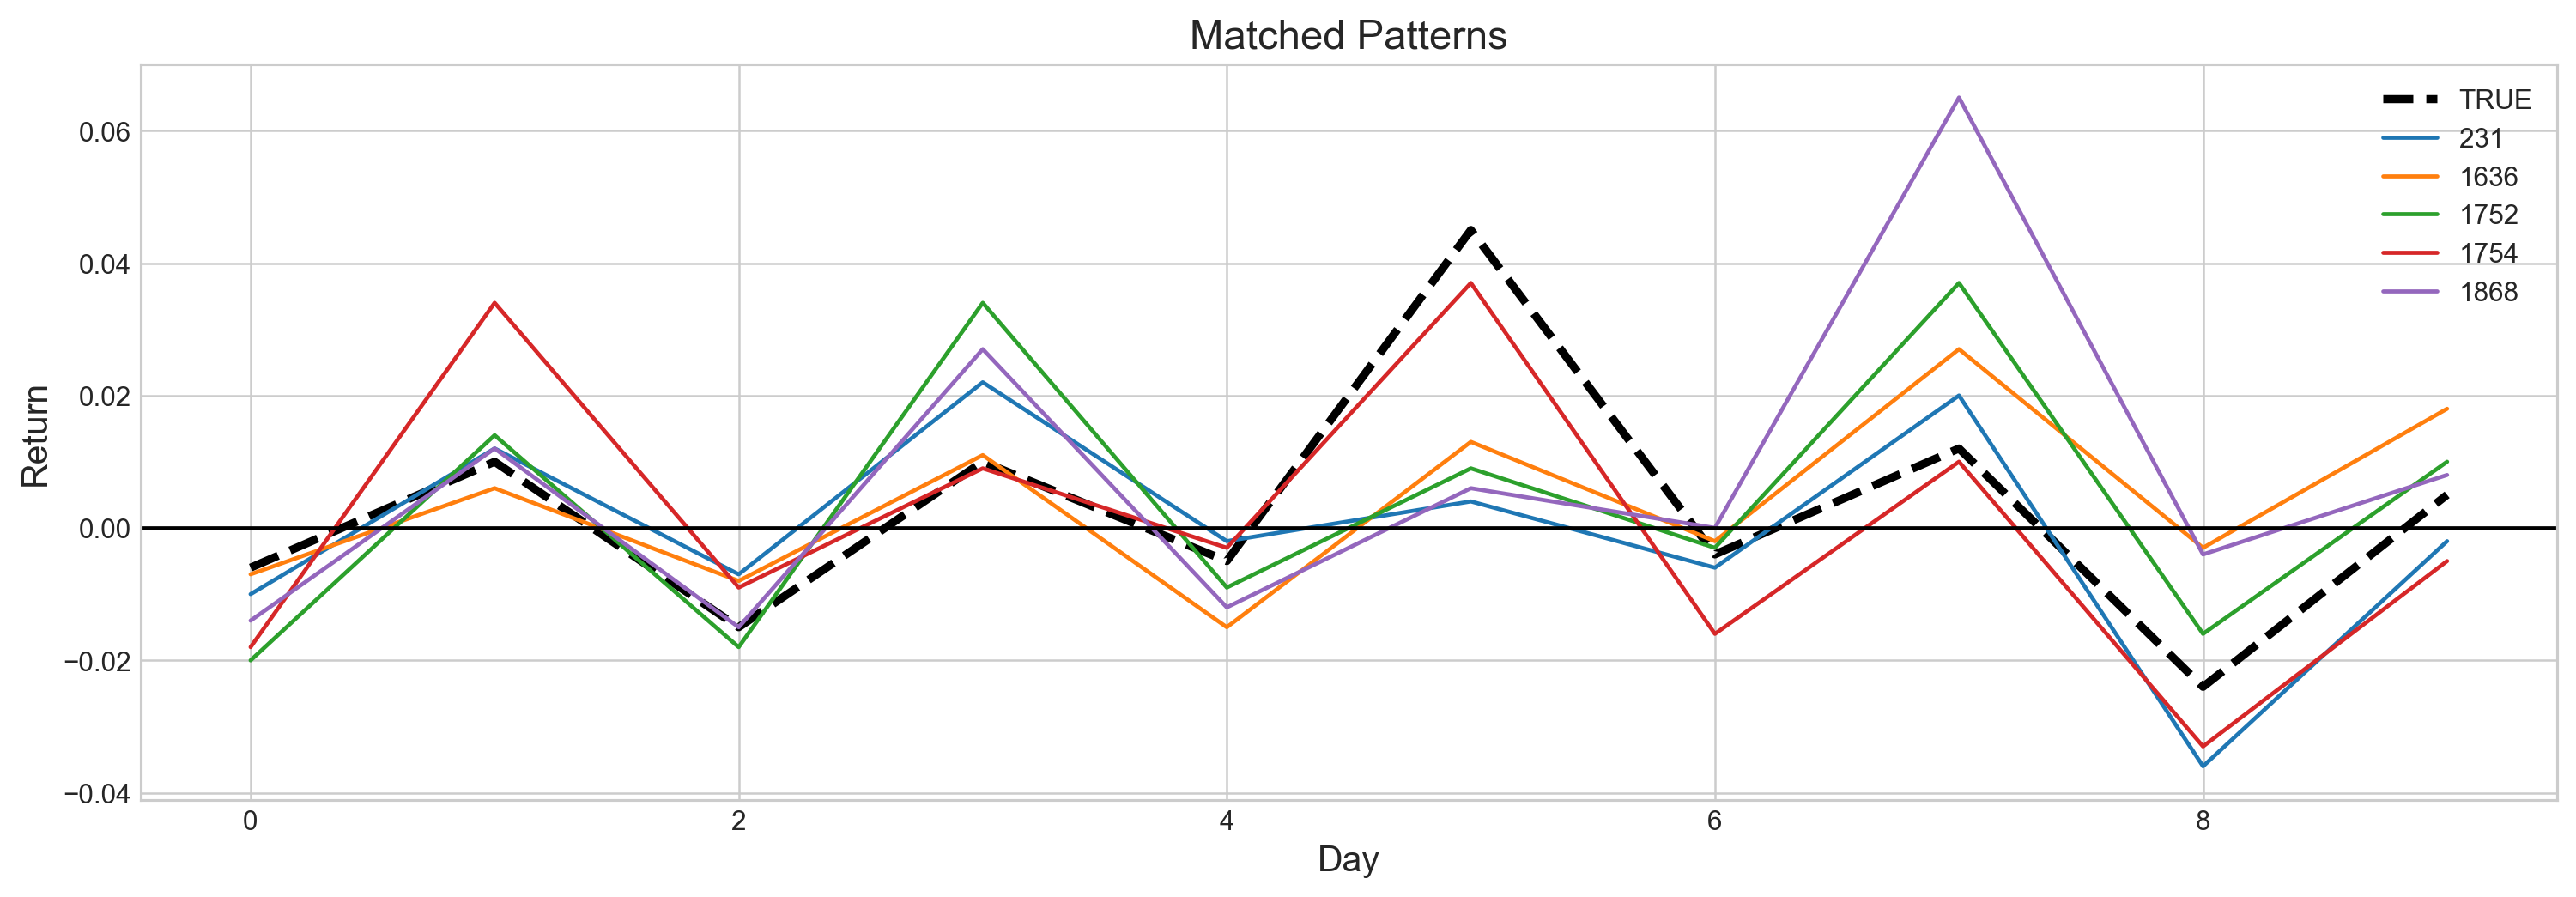

In [202]:
# https:/onepagecode.substack.com
start = 1
window = 9
a = []

sample = binary_test[start:start+window]
for i in range(len(binary_train)-window):
    if accuracy_score(binary_train[i:i+window], sample) == 1.0: a.append(i)

plt.figure(figsize=(16,5))
plt.plot(stocks['tsla'][2000+start:start+2010].Return.values, label='TRUE', ls='--', lw=3, c='k')
[plt.plot(stocks['tsla'].Return[i:i+10].values, label=i) for i in a]
plt.axhline(0, c='k')
plt.title('Matched Patterns', fontSize=15)
plt.xlabel('Day', fontSize=13)
plt.ylabel('Return', fontSize=13)
plt.legend()
plt.show()

This code is a part of a stock prediction system using machine learning. The code begins by initializing variables, setting the value of 'start' as 1 and 'window' as 9.   Next, an empty list 'a' is defined.   Then, a sublist 'sample' is created from a larger list called 'binary_test', starting from the 'start' index and continuing for 'window' number of elements.  A for loop iterates through the range of 'binary_train' list length minus the 'window' value. Inside the loop, it checks if the accuracy score between the sublists of 'binary_train' and 'sample' is equal to 1.0. If it is, the index 'i' is appended to the list 'a'.  After that, a matplotlib figure is created with specified dimensions. Then, it plots the 'Return' values of the 'tsla' stock from a subset of the 'stocks' dataset, corresponding to the 'start' and 'start+2010' indices, using a dashed line.   Additionally, for each index value in the list 'a', it plots the 'Return' values of the 'tsla' stock from the 'stocks' dataset, corresponding to the index value and the index value plus 10, with a different label for each plot.  Furthermore, it adds a horizontal line at y=0, sets a title for the plot, and labels the x and y axes. Finally, it displays the legend and shows the plot.

## Visual Comparison

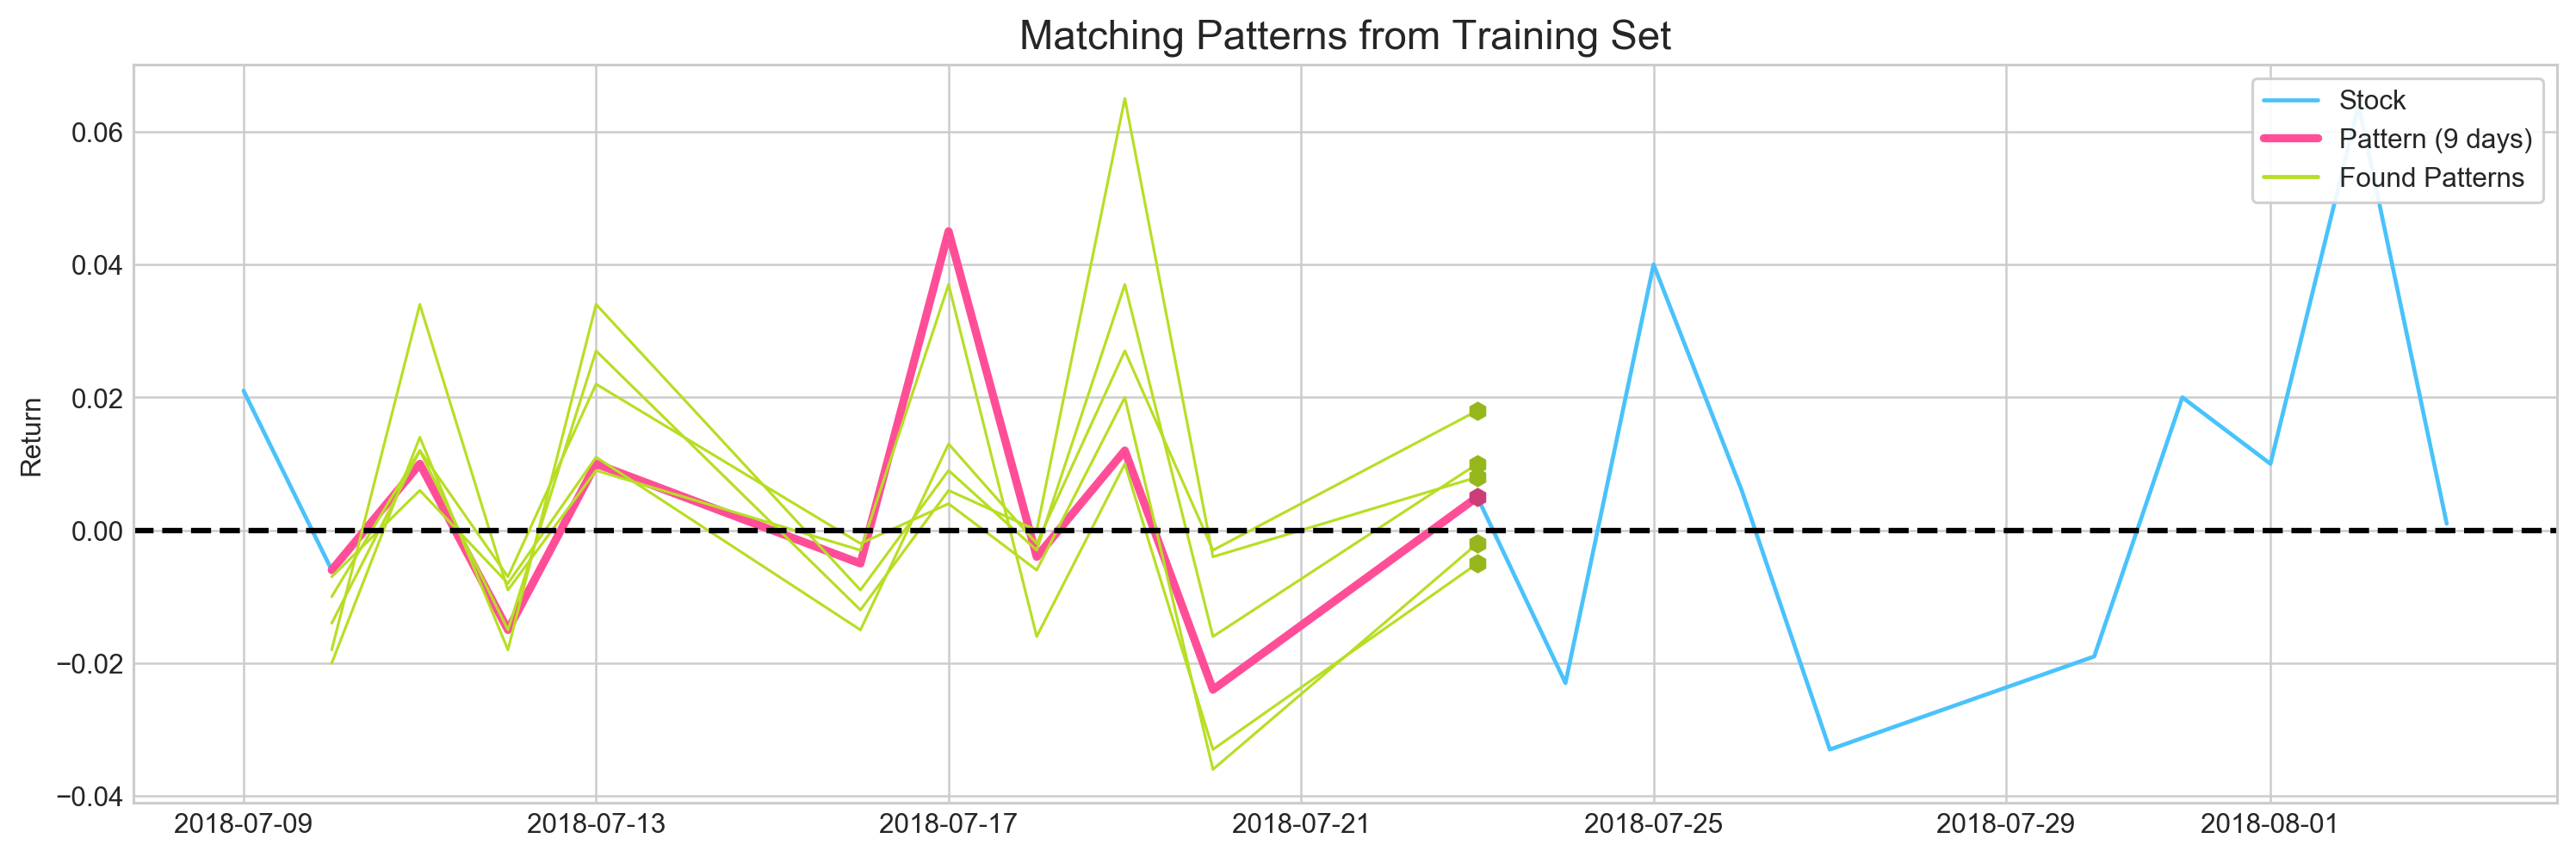

In [247]:
# https:/onepagecode.substack.com
indexes = stocks['tsla'][2001:2011].Return.index

plt.figure(figsize=(16,5))
plt.plot(stocks['tsla'][2000:2020].Return, label='Stock', c='#4ac2fb')
plt.plot(stocks['tsla'][2001:2011].Return, lw=3, label='Pattern (9 days)', c='#ff4e97')
plt.plot(stocks['tsla'][2010:2011].Return, 'h', c='#cc3d78')

for i in a:
    ret = stocks['tsla'][i:i+10].set_index(indexes).Return
    plt.plot(ret, lw=1, c='#b7de24')
    plt.plot(ret[9:], 'h', c='#96b71c')

plt.plot([],[], label='Found Patterns', c='#b7de24') # dummy plot for legend

plt.axhline(0, c='k', lw=2, ls='--')
plt.legend(frameon=True, fancybox=True, framealpha=.9, loc=1)
plt.title('Matching Patterns from Training Set', fontSize=15)
plt.ylabel('Return')
plt.show()

This code plots a stock's return data and highlights certain patterns within the data. It retrieves the indexes of the selected stock's returns from a specific time period and plots the stock's returns from 2000 to 2020. It also plots a specific pattern (9 days) within the returns data starting from 2001 to 2010. Additionally, it plots the returns data for a specific period (2010 to 2011) with markers.   The code then loops through a list of values and retrieves a specific subset of returns data for each value in the list. It plots these subsets of returns data with a thinner line. It also plots markers for each subset of returns data starting from the 10th data point.   Finally, some dummy plots are added for creating a legend, and horizontal line is drawn at y=0. The legend, title, and labels for the plot are added, and the plot is displayed.

### Conclusion

Accuracy varies depends on the section of the train data we're working on. Results are inconsistent, but generally approaching baseline model results.

# 7. Q-Learning

## 7.1 Using MACD to Make Decision

Number of Trades: 18
Time Frame: 343 days
Profit: $-1760.04 | -11.73%


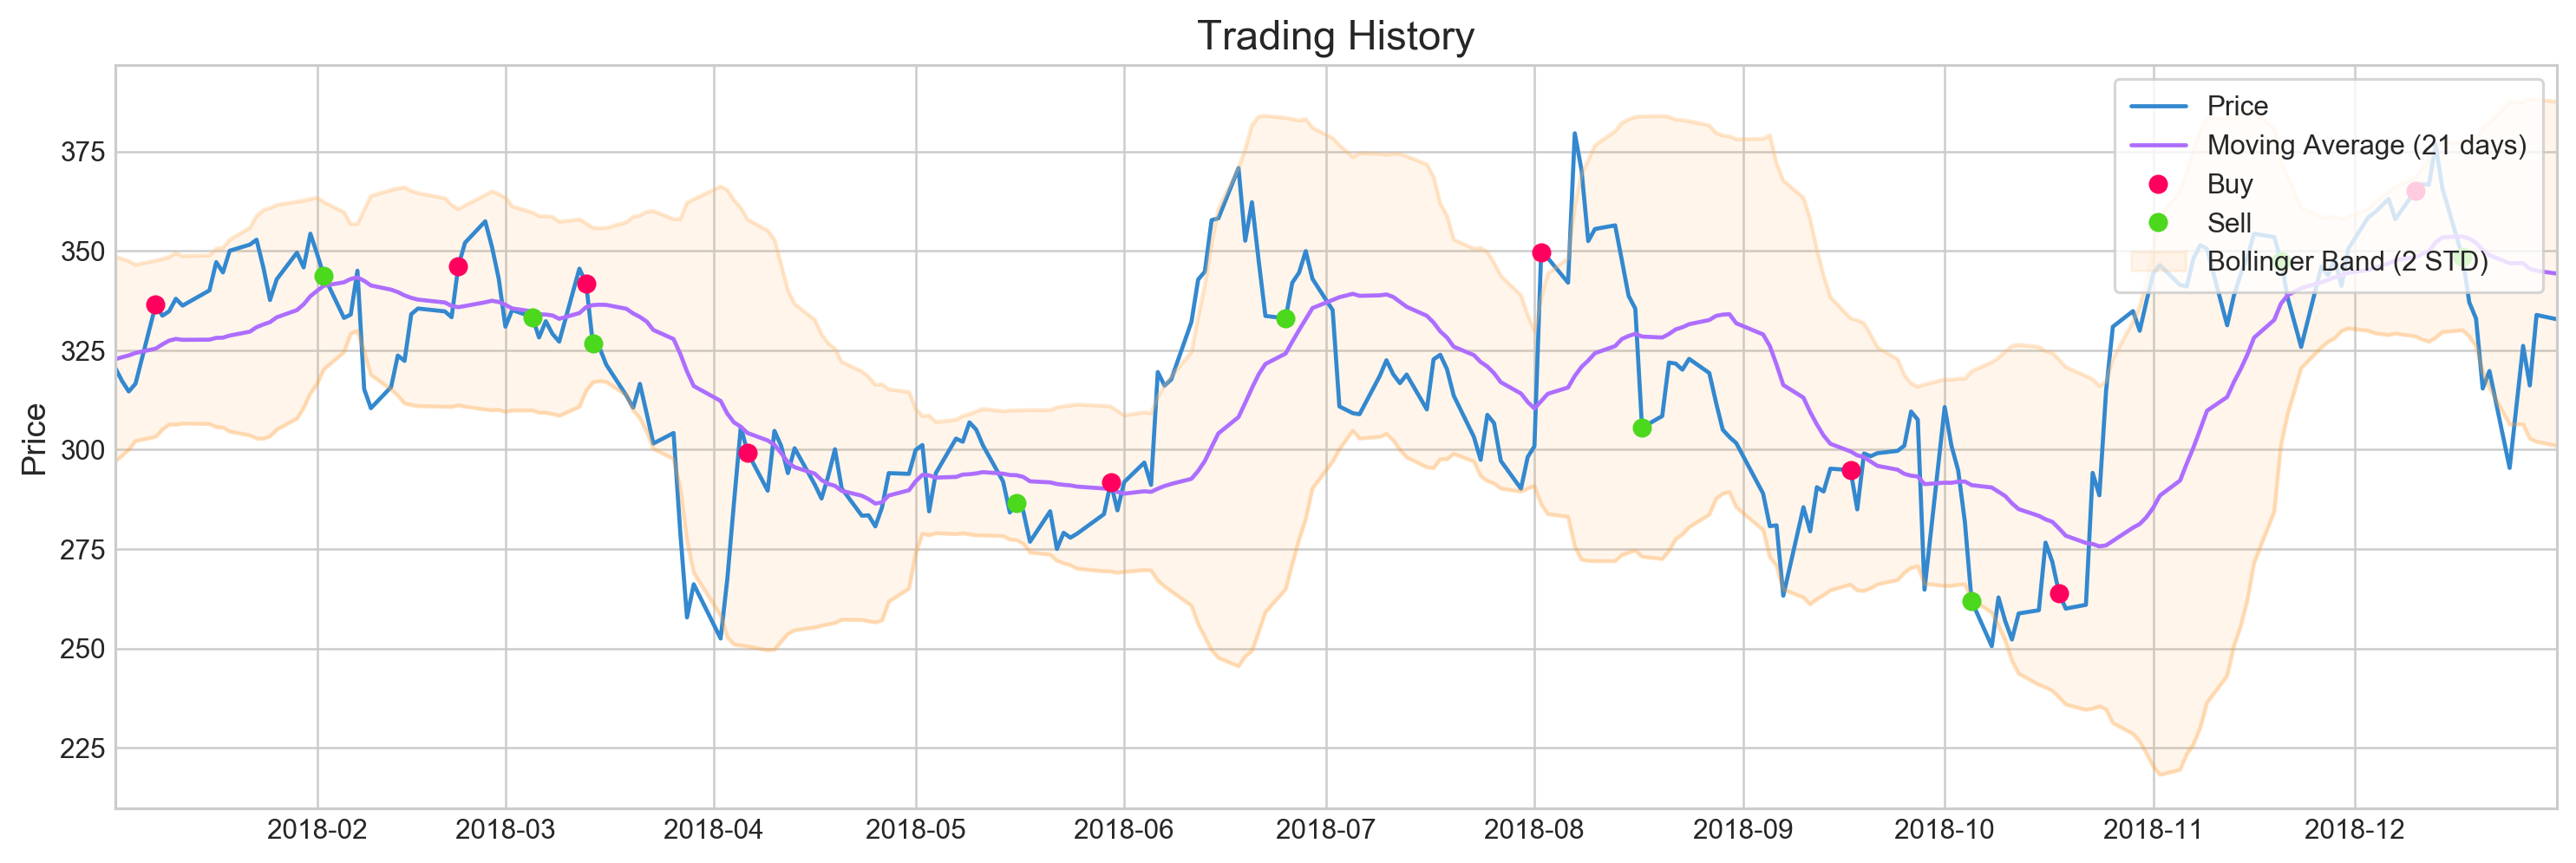

In [29]:
# https:/onepagecode.substack.com
profit, trades = functions.macd_trading(stocks['tsla'].loc['2018':'2018'])

This line of code calls the function `macd_trading` from a module called `functions`. It takes the stock data for the company Tesla from the year 2018 and applies the MACD (Moving Average Convergence Divergence) trading strategy. The function returns the profit and number of trades made using this strategy for the given stock data.

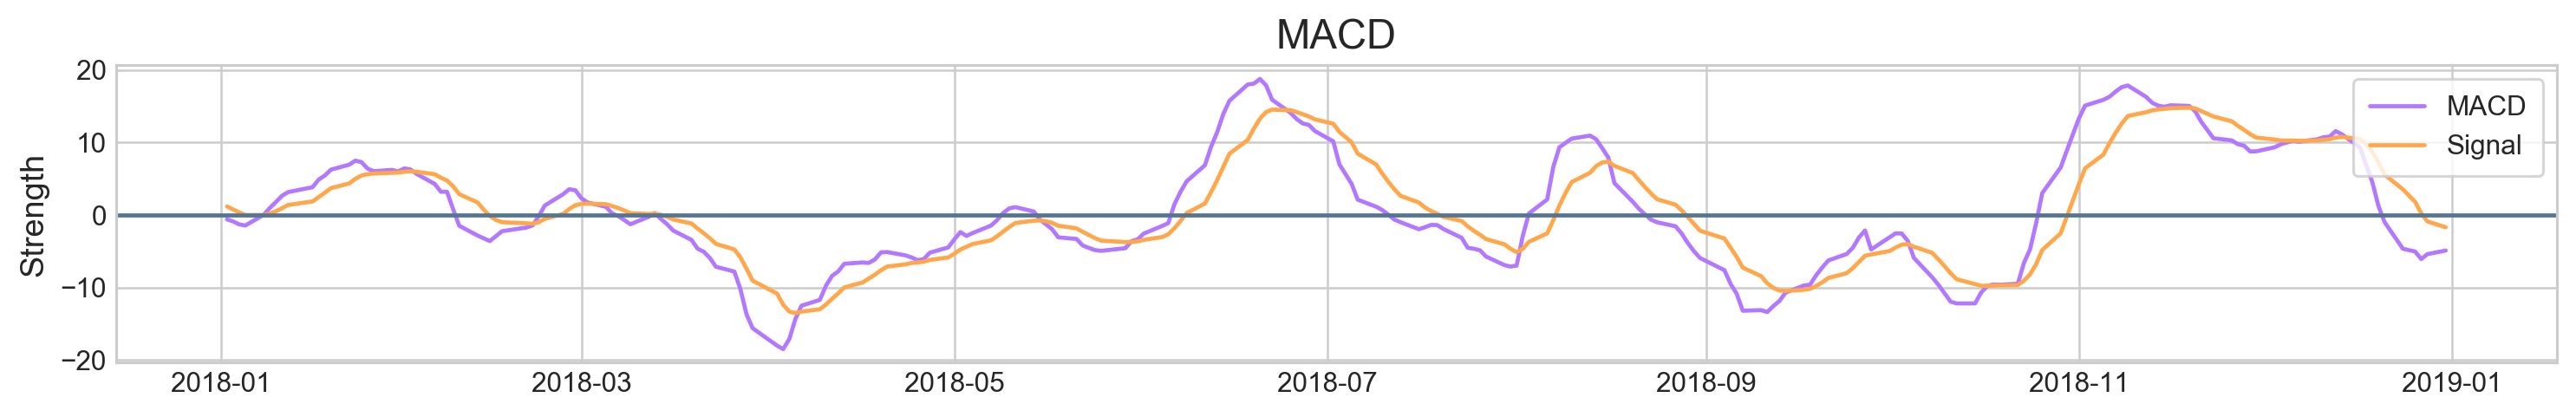

In [30]:
# https:/onepagecode.substack.com
plotting.macd(stocks['tsla'].loc['2018':'2018'])

This code is used to plot the Moving Average Convergence Divergence (MACD) indicator for the stock prices of Tesla (TSLA) during the year 2018. The MACD is a popular technical analysis tool used to identify potential buying and selling signals. By plotting the MACD, the code visualizes the changes and trends in the stock prices of TSLA during the specified time period.

### Returns

In [31]:
# https:/onepagecode.substack.com
companies = [i for i in stocks]
returns = []
for i in stocks:
    profit, trades = functions.macd_trading(
        stocks[i].loc['2018':'2018'], 
        budget=5000, 
        show_graph=False, 
        show_return=False
    )
    returns.append(round(profit*100 / 5000, 2))

This code aims to calculate the returns on stocks for a given set of companies using a machine learning algorithm.   First, it creates a list of companies from the 'stocks' dataset.   Then, it initializes an empty list called 'returns' to store the returns for each company.   Next, it goes through each company in the 'stocks' dataset and calls a function called 'macd_trading' with specific parameters including the stock data for that company in the year 2018, a budget of $5000, and set options to not show the graph and return.   The 'macd_trading' function returns the profit and number of trades made for that company.   The profit is then appended to the 'returns' list after calculating it as a percentage of the initial budget (5000) and rounding it to two decimal places.

In [32]:
# https:/onepagecode.substack.com
pd.DataFrame({'Company': companies, 'Return (%)': returns}).sort_values(by='Return (%)', ascending=False)

Company  Return (%)
10    twtr       63.33
14    shop        6.32
1     orcl       -1.79
16    qcom       -3.53
5     msft      -10.93
13     vmw      -11.20
0     csco      -12.03
2     ebay      -16.27
17    aapl      -18.76
9      ibm      -23.01
11    nflx      -25.06
4     intc      -25.09
6       ea      -34.87
12    tsla      -37.28
8       fb      -51.98
7     nvda      -62.73
15    goog     -100.00
3     amzn     -100.00

This code creates a pandas DataFrame with two columns - 'Company' and 'Return (%)'. The values in the 'Company' column are taken from the variable 'companies', and the values in the 'Return (%)' column are taken from the variable 'returns'. The DataFrame is then sorted based on the values in the 'Return (%)' column in descending order.

### Conclusion

You're going to lose money if you use MACD 

## 7.2 Using Bollinger Bands to Make Decision

Number of Trades: 19
Time Frame: 316 days
Profit: $15332.70 | 102.22%


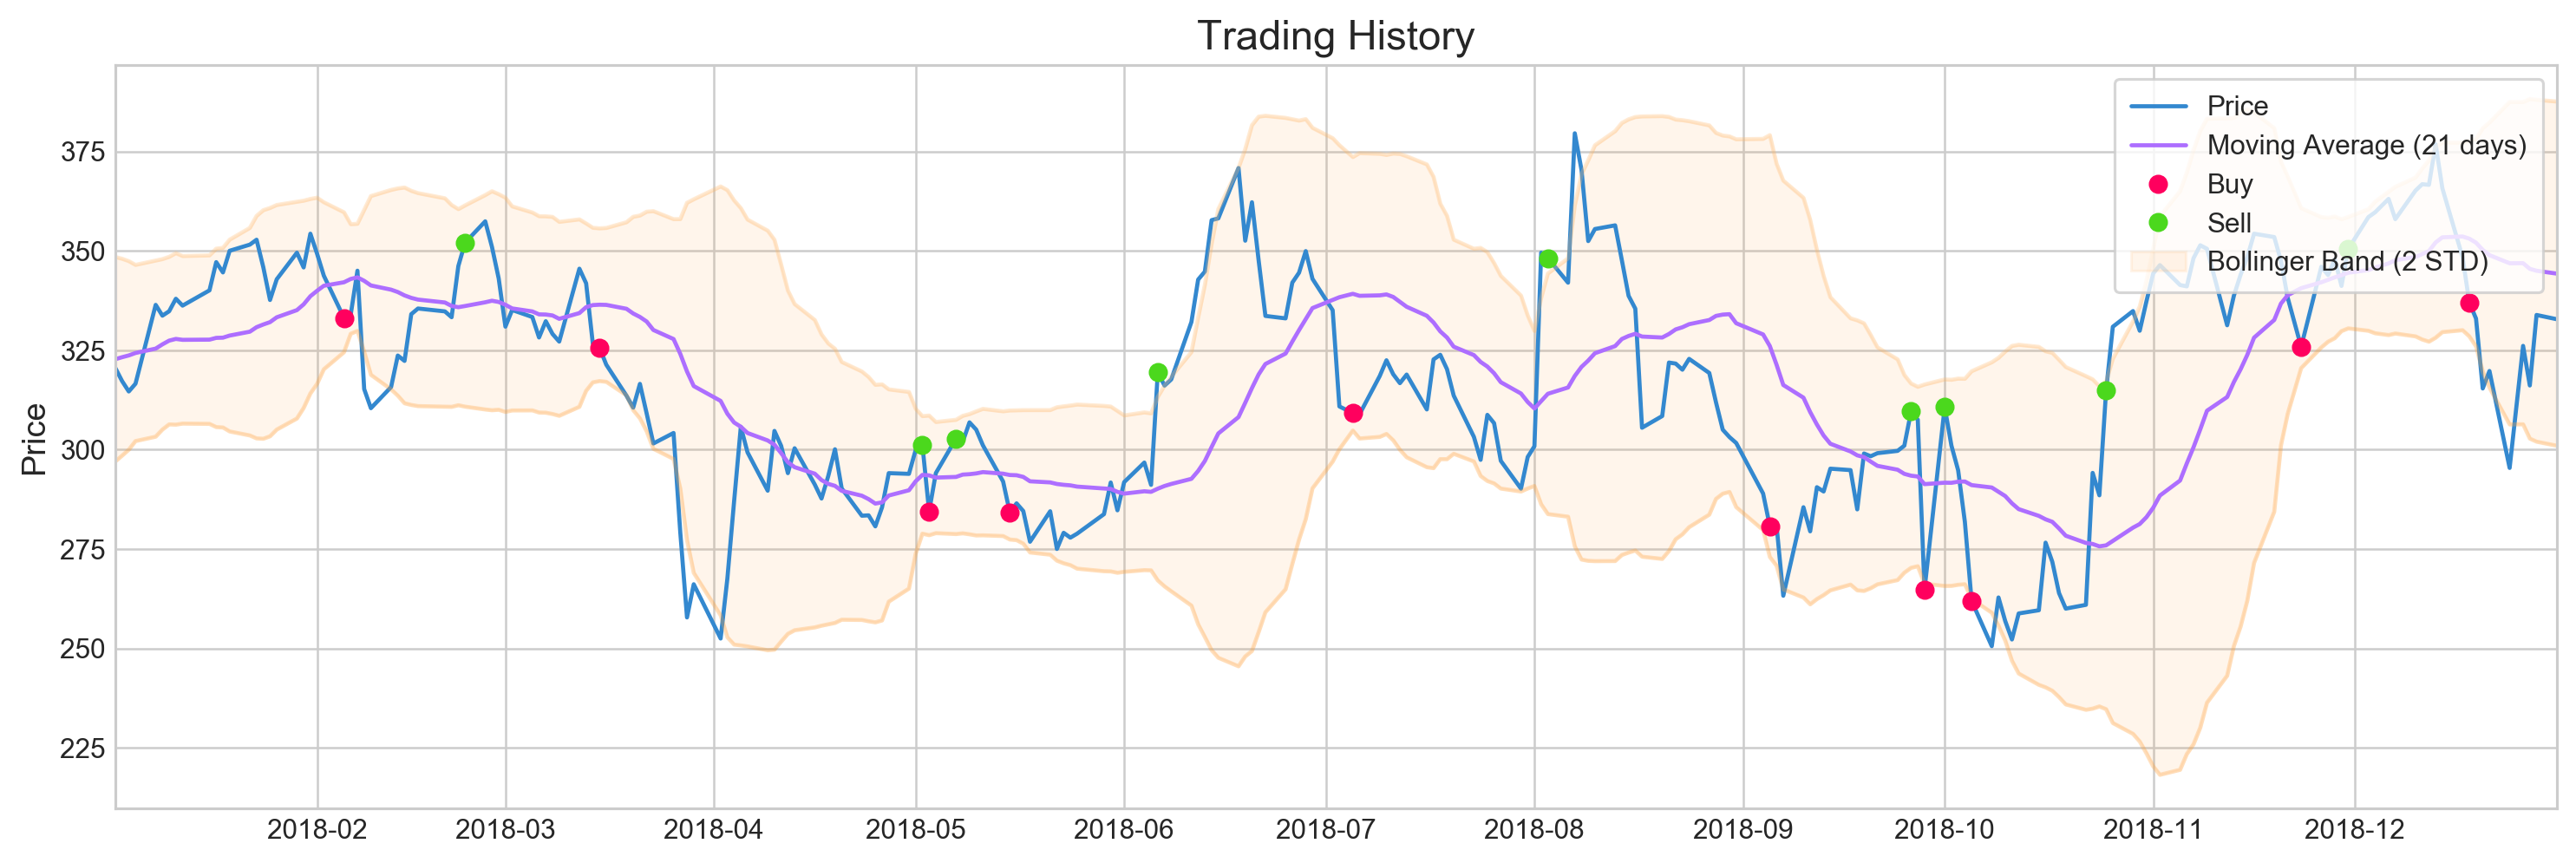

In [33]:
# https:/onepagecode.substack.com
profit, trades = functions.bb_trading(stocks['tsla'].loc['2018':'2018'], u=0.03, l=0.03)

This line of code is calling a function called "bb_trading" from the "functions" module. It is passing the stock data for the 'tsla' stock for the year 2018 as an argument. The function is designed to perform a trading strategy based on Bollinger Bands, which are a technical indicator used in stock trading. The function calculates the profit and number of trades made using the upper and lower thresholds of 0.03. The values of profit and trades will be assigned the respective values returned by the function.

### Returns

In [34]:
# https:/onepagecode.substack.com
companies = [i for i in stocks]
returns = []
for i in stocks:
    profit, trades = functions.bb_trading(
        stocks[i].loc['2018':'2018'], 
        budget=5000, 
        u=0.03, 
        l=0.03, 
        show_graph=False, 
        show_return=False
    )
    returns.append(round(profit*100 / 5000, 2))

This code retrieves a list of company names from the variable "stocks" and assigns it to the "companies" list. Then, it initializes an empty list called "returns".   Next, it iterates over each company in the "stocks" variable. For each company, it calls the function "bb_trading" with certain parameters. The function is passed a slice of the company's stock data for the year 2018, a budget of $5000, upper and lower threshold values, and flags to not show a graph or return value.   The function returns a profit value and the number of trades made. The code then calculates the percentage profit by dividing the profit by the budget and multiplying by 100. The obtained value is rounded to two decimal places. Finally, the percentage profit is appended to the "returns" list.

In [35]:
# https:/onepagecode.substack.com
pd.DataFrame({'Company': companies, 'Return (%)': returns}).sort_values(by='Return (%)', ascending=False)

Company  Return (%)
12    tsla       88.74
4     intc       38.42
0     csco       26.41
13     vmw       21.79
1     orcl       20.43
7     nvda       16.94
14    shop        8.91
17    aapl        7.89
11    nflx        5.41
5     msft        2.89
10    twtr        2.52
8       fb      -20.06
6       ea      -20.35
2     ebay      -23.67
9      ibm      -33.17
16    qcom      -35.28
15    goog      -59.34
3     amzn      -70.78

This code creates a Pandas DataFrame using two lists - 'companies' and 'returns'. The 'companies' list contains the names of various companies, and the 'returns' list contains the corresponding return percentages for each company.  The DataFrame is then sorted in descending order based on the 'Return (%)' column using the sort_values() function. This means that the companies with the highest return percentages will be displayed at the top of the DataFrame.  The resulting DataFrame will provide a sorted view of the companies and their return percentages, allowing users to easily identify which companies have performed the best in terms of returns.

# Conclusion

- ARIMA model can't surpass baseline model accuracy due to the historical data stochastic behaviour.
- Convolutional model prone to overfitting, resulting on very good accuracy on training set, and extremely poor accuracy on testing set.
- Recurrent (LSTM) neural network can't learn from training data, averaging on 50% accuracy both on training and testing data
- Bayesian optimization didn't improve accuracy of convolutional network
- Neural Network architecture and complexity doesn't affect results of the model performance
- Predictions based on matching patterns from testing data with patterns from testing didn't surpass 50% accuracy
- **Q-Learning, specifically Bollinger Bands showed good results for short term investment**

# Future Work

- Incorporate fundamental analysis with historical data
- Add recommendations from trading platforms
- Use twitter as a supplement to news data
- Expand analysis to stock from different industries
- Add more rules to swing trading strategy with technical indicators